<b>Data mining Project - 2021/22</b><br/>
<span>
<b>Authors:</b> Mariagiovanna Rotundo (560765), Nunzio Lopardo (600005)</a> and Renato Eschini (203021)<br/>
<b>Group:</b>3<br/>
<b>Release date:</b> 26/12/2021
</span>

# Classification task

In this notebook we use different classificators for the classification task and we evaluate the performaces. The used dataset is the dataset of player created in the preparation notebook. 
Sunce the dataset for train and test are imbalanced, for the classification task 3 different approaches are evaluated:
1. the classification is done on the train and testset without considering the imbalance
2. the classification is done on the train and test given different weight to the 2 classes (high rank and low rank)
3. the classification is done on oversapled train and testset using SMOTE

The classificator are the follows:
- **Decision Tree**
- **Support Vector Machine**
- **Rule Based**
- **Gaussain Naive Bayes**
- **AdaBoost**
- **Random Forest**
- **Neural Network**
- **k-Nearest Neighbors**

**Import libraries**

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import collections
import pydotplus 
import statistics 
import pandas as pd
import os
from datetime import date
from tqdm.notebook import tqdm
from IPython.display import Image  
import scikitplot as skplt
import wittgenstein as lw
from imblearn.over_sampling import SMOTE

from scipy.stats.stats import pearsonr
from scipy.spatial.distance import pdist,  squareform
import scipy.stats as stats
from scipy.stats import randint as sp_randint

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, pairwise_distances, classification_report, plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay # For Model evaluation
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn import tree, metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns
import re

**Loading the dataset**

In [2]:
# load of the data
DATASET_DIR = '..' + os.path.sep + "dataset" + os.path.sep
#index_col=False say to not use the first column as ID
df_players = pd.read_csv(DATASET_DIR + 'players.csv', sep=',', index_col=0)

In [3]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10102 entries, 0 to 10102
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   whole_name        10102 non-null  object 
 1   sex               10102 non-null  object 
 2   ioc               10102 non-null  object 
 3   id                10102 non-null  float64
 4   hand              10102 non-null  object 
 5   best_rank         10102 non-null  int64  
 6   best_rank_points  10102 non-null  int64  
 7   best_of_3_match   10102 non-null  int64  
 8   best_of_5_match   10102 non-null  int64  
 9   best_of_3_wins    10102 non-null  int64  
 10  best_of_5_wins    10102 non-null  int64  
 11  m_16              10102 non-null  int64  
 12  w_16              10102 non-null  int64  
 13  m_17              10102 non-null  int64  
 14  w_17              10102 non-null  int64  
 15  m_18              10102 non-null  int64  
 16  w_18              10102 non-null  int64 

## Functions

In this section are defined the functions used in the notebook. 

**function to discretize categorical data**

In [4]:
def discretize_data(dataset, variables): #mapping categorical into numerical
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())
        
        #generate a mapping from the variable's values to the number representation  
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new colum with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [5]:
#metrics computed on the test set
def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                            test_pred, 
                            target_names=['low', 'high']))

In [6]:
#metrics computed on the test set
def compare_scores(models,test_set, test_label):
    for model in models.keys():
        print('\t\t\t' + model)
        test_pred =  models[model].predict(test_set)
        report_scores(test_label, test_pred)

In [7]:
def spot_errors(test_label, test_pred):
    spotted_errors = []
    for i in range(len(test_label)):
        if(test_label.array[i]!= test_pred[i]):
            spotted_errors.append('darkred')
        else:
            spotted_errors.append('darkgray')
    return spotted_errors

**Plot the neural network training history**

In [8]:
def plot_nn_training_history(history):
    from matplotlib.pyplot import figure
    fig, (acc_plot, loss_plot) = plt.subplots(2, figsize=(15, 6), dpi=240)
    fig.suptitle('Accuracy and Loss trends')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    acc_plot.plot(epochs, acc, label='Training Acc')
    acc_plot.plot(epochs, val_acc, label='Validation Acc')
    acc_plot.legend(loc='best')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.set_ylim([0,1])
    acc_plot.grid(True)
    loss_plot.plot(epochs, loss, label='Trining Loss')
    loss_plot.plot(epochs, val_loss, label='Validation Loss')
    loss_plot.legend(loc='best')
    loss_plot.set_ylabel('Loss')
    loss_plot.set_ylim([0,1])
    loss_plot.set_xlabel('Epochs')
    loss_plot.grid(True)

**Scatter plot comparison real/classified/misclassified data**

In [9]:
def scatter_pred_data(test_set, test_label, test_pred, classifier_name, x, y):
    fig, (test_true_plt, test_pred_plt, errors_plt) = plt.subplots(1,3, figsize=(18,6), sharey=True)
    title = classifier_name + ' | Real vs Predicted labels'
    plt.suptitle(title)
    test_true_plt.set_title('True Label')
    test_true_plt.set_xlabel(x)
    test_true_plt.set_ylabel(y)
    test_true_plt.scatter(test_set[x].values, test_set[y].values, c=test_label.values, s=25, cmap='viridis')
    test_pred_plt.set_title('Predicted Label')
    test_pred_plt.set_xlabel(x)
    test_pred_plt.scatter(test_set[x].values, test_set[y].values, c=test_pred, s=25, cmap='viridis')
    spotted_errors = spot_errors(test_label, test_pred)
    errors_plt.set_title('Misclassification')
    errors_plt.set_xlabel(x)
    errors_plt.scatter(test_set[x].values, test_set[y].values, c=spotted_errors, s=25, cmap='viridis')
    plt.show()

**Print the dataset composition**

In [10]:
def print_dataset_composition(train_set, train_labels, test_set, test_labels):
    print(f"{len(train_labels)} training samples:")
    print(f"\t- {len(train_labels[train_labels == 0])} samples for the class Low Rank")
    print(f"\t- {len(train_labels[train_labels == 1])} samples for the class High Rank")
    print(f"\n{len(test_labels)} test samples:")
    print(f"\t- {len(test_labels[test_labels == 0])} samples for the class Low Rank")
    print(f"\t- {len(test_labels[test_labels == 1])} samples for the class High Rank")

**Plot the ROC curve and compute the AUC**

In [11]:
def roc_curve_plot(model, test_set, test_label, classifier_name):
    x_test = np.reshape(test_set.values, (len(test_set), 1, len(test_set.columns)))
    y_pred_keras = (model.predict(x_test) > 0.5).astype("int32")
    fpr, tpr, thresholds = roc_curve(test_label, y_pred_keras)
    auc_area = auc(fpr, tpr)
    label_name = classifier_name + '(area = {:.3f})'.format(auc_area)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label_name)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

**Plot used to compare multiple ROC curves and AUC**

In [12]:
def compare_roc_curves(models, test_set, test_label, norm_test_set = None):
    result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
    for model in models.keys():
        if ((model == 'nn_original') or (model =='nn_weighted') or ( model=='nn_ov')):
            norm_test_set = normalize_dataset(test_set)
            x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
            pred =  (models[model].predict(x_test) > 0.5).astype("int32")
        elif ("knn" in model):
            knn_test_set = test_set.drop(columns=['sex_num', 'hand_num'])
            pred = models[model].predict(knn_test_set)
        else:     
            pred = models[model].predict(test_set)
    
        fpr, tpr, _ = roc_curve(test_label, pred)
        auc_score = auc(fpr, tpr)
        result_table = result_table.append({'classifiers':model,
                                    'fpr':fpr, 
                                    'tpr':tpr, 
                                    'auc':auc_score}, ignore_index=True)
    result_table.set_index('classifiers', inplace=True)
    fig = plt.figure(figsize=(8,6))

    for i in result_table.index:
        plt.plot(result_table.loc[i]['fpr'], 
                 result_table.loc[i]['tpr'], 
                 label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

    plt.plot([0,1], [0,1], color='orange', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()

**Plot confusion matrix**

In [13]:
def plot_confusion_mx(test_label, test_pred):
    cm = confusion_matrix(test_label, test_pred, labels=[1,0])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= ['high', 'low'])
    disp.plot()
    plt.show()

**Plot multiple confusion matrix**

Given a dictionary of trained classifiers ({classifier_name: model}) plots the confusion matrix for all of them.

In [14]:
def compare_models(models_list, classifier_name, test_set, test_label):
    i = 0
    col_count = len(train_set.columns)
    fig, axs = plt.subplots(nrows=1,ncols=len(models_list), figsize=(18,6), sharey=True)
    title = classifier_name + ' | Confusion Matrix comparison'
    plt.suptitle(title)
    for model in models_list.keys():
        test_pred =  models_list[model].predict(test_set)
        cm=confusion_matrix(test_label,test_pred)
        sns.heatmap(cm, ax=axs[i], annot=True,cmap=plt.cm.Blues, fmt='g')
        axs[i].set_title(model)
        i+=1

**Function to normalize a dataframe**

In [15]:
def normalize_dataset(df):
    cols_to_norm = ['best_rank_points', 'w_tourney', 'tot_minutes', 'sv1st', 'sv1st_win', 'sv2nd_win', 
           'df', 'ace', 'bpS', 'wmatch', 'lmatch', 'nmatch', 'n_tourney']
    df_norm = df.copy()
    df_norm[cols_to_norm] = MinMaxScaler().fit_transform(df_norm[cols_to_norm])
    return df_norm

## Data for classification

Selection of the colmuns that will be used to define train and testset and to define the labels. To establish if a player is high or low ranked we use the "best_rank" column

In [16]:
df_filtered = df_players[['sex', 'hand','best_rank','best_rank_points', 'w_tourney', 'tot_minutes', 'sv1st', 'sv1st_win', 'sv2nd_win', 
           'df', 'ace', 'bpS', 'wmatch', 'lmatch', 'nmatch', 'n_tourney']]

Discretization of sex and hand values since they are categorical values

In [17]:
variables = ['sex', 'hand']
df_filtered = discretize_data(df_filtered, variables)

/tmp/ipykernel_33948/1047296706.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)


In [18]:
df_filtered = df_filtered.drop(columns=['sex', 'hand'])

In [19]:
df_filtered

best_rank  best_rank_points  w_tourney   tot_minutes  sv1st  sv1st_win  \
0              4              5010          3  33023.911876  14032       9825   
1              2             10620         14  38112.287152  16455      12334   
2              7              3480          7  21506.786448   9433       7474   
3             28              1265          1  28833.134645  13288       9835   
4             15              2690          6  29048.475556  12382       8699   
...          ...               ...        ...           ...    ...        ...   
10098          0                 0          0     44.112350      0          0   
10099          0                 0          0     73.520583      0          0   
10100          0                 0          0     55.140437      0          0   
10101          0                 0          0    128.661020      0          0   
10102          0                 0          0     51.464408      0          0   

       sv2nd_win    df     ace     bpS  wmatch  lmatch  nmatch  n_tourney  \
0           4689   644   872.0  1154.0     191      92     283         91   
1           5789  1205  2854.0  1305.0     267     115     382        129   
2           3168   504  1917.0   636.0     125      72     197         82   
3           3998  1119  2227.0  1049.0     149     131     280        133   
4           4431   742   968.0  1051.0     164     108     272        114   
...          ...   ...     ...     ...     ...     ...     ...        ...   
10098          0     0     0.0     0.0       0       1       1          1   
10099          0     0     0.0     0.0       0       1       1          1   
10100          0     0     0.0     0.0       0       1       1          1   
10101          0     0     0.0     0.0       0       1       1          1   
10102          0     0     0.0     0.0       0       1       1          1   

       sex_num  hand_num  
0            1         1  
1            1         1  
2            1         1  
3            1         1  
4            1         1  
...        ...       ...  
10098        0         2  
10099        0         2  
10100        0         2  
10101        0         2  
10102        0         2  

[10102 rows x 16 columns]

We consider as high ranked the players that are in the first 50 position

In [20]:
threshold = 50
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']<=threshold)), 'ranked'] = 1 #high
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']>threshold)), 'ranked'] = 0 #low

In [21]:
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']<=threshold))].shape[0] #number of high

255

In [22]:
df_filtered.loc[((df_filtered['best_rank']>0) & (df_filtered['best_rank']>threshold))].shape[0] #number of low

4192

255 players are considered high ranked and 4192 are considered low ranked. For the classification task we do not consider the players for which we cannot establish the rank using the best_rank value

In [23]:
df_classification = df_filtered[df_filtered['best_rank']>0]

In [24]:
df_classification = df_classification.drop(columns=['best_rank'])

In [25]:
df_classification

best_rank_points  w_tourney   tot_minutes  sv1st  sv1st_win  sv2nd_win  \
0                 5010          3  33023.911876  14032       9825       4689   
1                10620         14  38112.287152  16455      12334       5789   
2                 3480          7  21506.786448   9433       7474       3168   
3                 1265          1  28833.134645  13288       9835       3998   
4                 2690          6  29048.475556  12382       8699       4431   
...                ...        ...           ...    ...        ...        ...   
9497              1865          0     78.000000     59         33          5   
9498              1505          0    213.000000    118         76         26   
9500              1511          0    117.000000     55         28         21   
9503              1644          0    176.000000     74         40         32   
9761              1175          0     62.492495      0          0          0   

        df     ace     bpS  wmatch  lmatch  nmatch  n_tourney  sex_num  \
0      644   872.0  1154.0     191      92     283         91        1   
1     1205  2854.0  1305.0     267     115     382        129        1   
2      504  1917.0   636.0     125      72     197         82        1   
3     1119  2227.0  1049.0     149     131     280        133        1   
4      742   968.0  1051.0     164     108     272        114        1   
...    ...     ...     ...     ...     ...     ...        ...      ...   
9497     2     1.0     7.0       0       1       1          1        1   
9498     5     4.0     9.0       0       1       1          1        1   
9500     5     1.0     9.0       0       1       1          1        1   
9503     2    11.0    12.0       0       1       1          1        1   
9761     0     0.0     0.0       0       1       1          1        0   

      hand_num  ranked  
0            1     1.0  
1            1     1.0  
2            1     1.0  
3            1     1.0  
4            1     1.0  
...        ...     ...  
9497         2     0.0  
9498         1     0.0  
9500         1     0.0  
9503         2     0.0  
9761         1     0.0  

[4447 rows x 16 columns]

Creation of training set and test set and their labels. To creare these sets we mantain the same proportions between the 2 class and we use a test set smaller than the training (test_size=0.30)

In [26]:
label = df_classification.pop('ranked')
train_set, test_set, train_label, test_label = train_test_split(df_classification, label, stratify = label, test_size=0.30)

**Dataset normalization**

In [27]:
norm_train_set = normalize_dataset(train_set)
norm_test_set = normalize_dataset(test_set)

In [28]:
norm_train_set

best_rank_points  w_tourney  tot_minutes     sv1st  sv1st_win  \
639           0.034607   0.074074     0.446085  0.335129   0.261459   
8145          0.074482   0.000000     0.001277  0.001744   0.001308   
3874          0.046162   0.000000     0.021423  0.006208   0.004611   
7258          0.096515   0.000000     0.007123  0.008055   0.005850   
2767          0.028619   0.037037     0.435485  0.415782   0.380798   
...                ...        ...          ...       ...        ...   
2807          0.049455   0.111111     0.168443  0.180134   0.168273   
4509          0.053946   0.000000     0.054638  0.000000   0.000000   
8248          0.040055   0.000000     0.000905  0.001077   0.000757   
3750          0.064783   0.000000     0.010297  0.011954   0.010530   
4116          0.059214   0.000000     0.179256  0.000000   0.000000   

      sv2nd_win        df       ace       bpS    wmatch    lmatch    nmatch  \
639    0.233464  0.288325  0.039792  0.453776  0.352941  0.688889  0.581395   
8145   0.000680  0.001015  0.000000  0.003906  0.000000  0.005556  0.000000   
3874   0.003401  0.006091  0.000474  0.003906  0.020761  0.033333  0.028424   
7258   0.006291  0.006091  0.000711  0.012370  0.000000  0.022222  0.007752   
2767   0.442102  0.227919  0.120559  0.489583  0.377163  0.466667  0.496124   
...         ...       ...       ...       ...       ...       ...       ...   
2807   0.152865  0.078173  0.078636  0.189453  0.169550  0.161111  0.198966   
4509   0.000000  0.000000  0.000000  0.000000  0.065744  0.105556  0.095607   
8248   0.001870  0.001523  0.000237  0.001953  0.000000  0.005556  0.000000   
3750   0.010542  0.005584  0.005448  0.013021  0.003460  0.022222  0.010336   
4116   0.000000  0.000000  0.000000  0.000000  0.169550  0.277778  0.253230   

      n_tourney  sex_num  hand_num  
639    0.706897        0         1  
8145   0.000000        1         1  
3874   0.028736        0         1  
7258   0.017241        1         2  
2767   0.482759        1         1  
...         ...      ...       ...  
2807   0.166667        1         1  
4509   0.103448        0         2  
8248   0.000000        0         1  
3750   0.017241        1         1  
4116   0.287356        0         2  

[3112 rows x 15 columns]

**Dataset composition**

In [29]:
print_dataset_composition(train_set, train_label, test_set, test_label)

3112 training samples:
	- 2934 samples for the class Low Rank
	- 178 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


# Classification

### Decision tree

In [30]:
dt_models = {}

**creation and fit**

In [31]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5)
dt = dt.fit(train_set, train_label)
dt_models['dt_original'] = dt

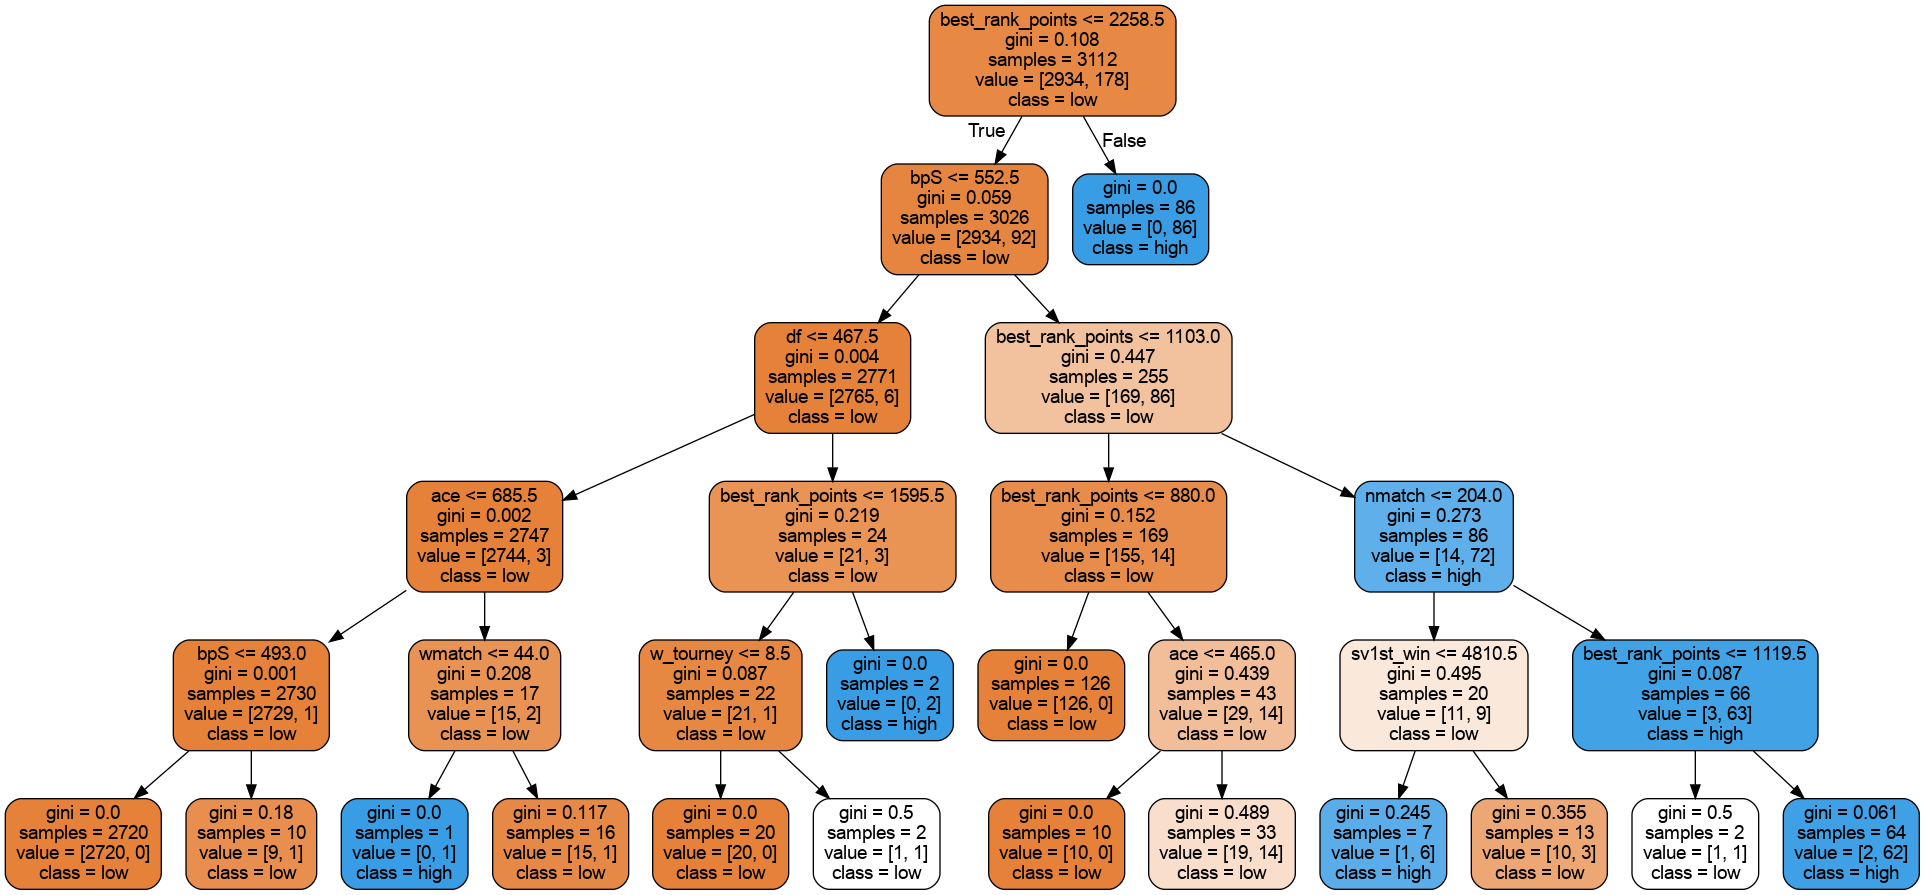

In [32]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'high'],  #[0, 1]
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

**prediction on train and test sets**

In [33]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

#### evaluation

In [34]:
#per il training set
report_scores(train_label, train_pred_dt)

              precision    recall  f1-score   support

         low       0.99      1.00      1.00      2934
        high       0.98      0.88      0.93       178

    accuracy                           0.99      3112
   macro avg       0.99      0.94      0.96      3112
weighted avg       0.99      0.99      0.99      3112



In [35]:
#per il test set
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.89      0.84      0.87        77

    accuracy                           0.99      1335
   macro avg       0.94      0.92      0.93      1335
weighted avg       0.98      0.99      0.98      1335



Confusion matrix

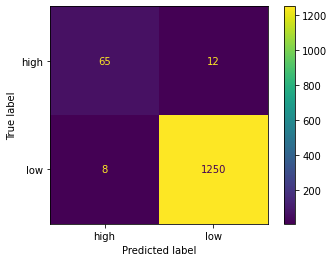

In [36]:
#plot the confusion matrix 
plot_confusion_mx(test_label, test_pred_dt)

**Example of plot with classification results**

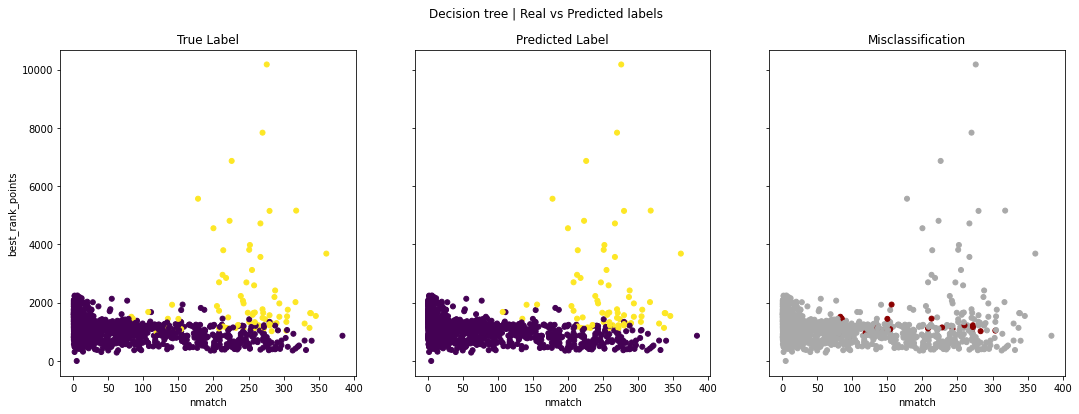

In [37]:
#true labels - different colors for different class
scatter_pred_data(test_set, test_label, test_pred_dt, 'Decision tree', 'nmatch', 'best_rank_points')

### SVM

In [38]:
svm_models = {}

**creation and fit**

In [39]:
svm = SVC(kernel='sigmoid', C=0.5, gamma='scale', probability=True)
svm.fit(train_set, train_label)
svm_models['svm_original'] = svm 

**prediction**

In [40]:
train_pred_svm = svm.predict(train_set)

In [41]:
test_pred_svm = svm.predict(test_set)

**evaluation**

In [42]:
report_scores(train_label, train_pred_svm)

              precision    recall  f1-score   support

         low       0.94      0.97      0.96      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.92      3112
   macro avg       0.47      0.49      0.48      3112
weighted avg       0.89      0.92      0.90      3112



In [43]:
#compute the performance of the model
report_scores(test_label, test_pred_svm)

              precision    recall  f1-score   support

         low       0.94      0.98      0.96      1258
        high       0.00      0.00      0.00        77

    accuracy                           0.92      1335
   macro avg       0.47      0.49      0.48      1335
weighted avg       0.89      0.92      0.90      1335



We can notice that this model classify all the players as low ranked

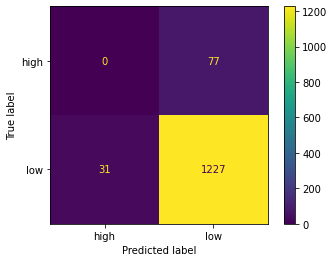

In [44]:
plot_confusion_mx(test_label, test_pred_svm)

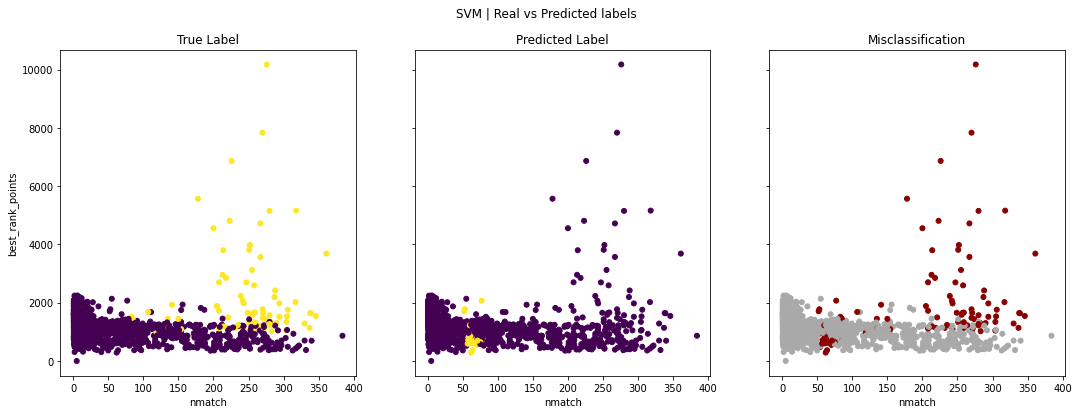

In [45]:
scatter_pred_data(test_set, test_label, test_pred_svm, 'SVM', 'nmatch', 'best_rank_points')

### Rule based

The used rule-based method is RIPPER

In [46]:
rb_models = {}

In [47]:
train_set

best_rank_points  w_tourney   tot_minutes  sv1st  sv1st_win  sv2nd_win  \
639                826          2  19234.318798   6532       3799       1373   
8145              1492          0     76.000000     34         19          4   
3874              1019          0    943.713333    121         67         20   
7258              1860          0    327.773370    157         85         37   
2767               726          1  18777.741421   8104       5533       2600   
...                ...        ...           ...    ...        ...        ...   
2807              1074          3   7276.000000   3511       2445        899   
4509              1149          0   2374.307517      0          0          0   
8248               917          0     60.000000     21         11         11   
3750              1330          0    464.520583    233        153         62   
4116              1237          0   7741.727614      0          0          0   

       df    ace    bpS  wmatch  lmatch  nmatch  n_tourney  sex_num  hand_num  
639   568  168.0  697.0     102     124     226        124        0         1  
8145    2    0.0    6.0       0       1       1          1        1         1  
3874   12    2.0    6.0       6       6      12          6        0         1  
7258   12    3.0   19.0       0       4       4          4        1         2  
2767  449  509.0  752.0     109      84     193         85        1         1  
...   ...    ...    ...     ...     ...     ...        ...      ...       ...  
2807  154  332.0  291.0      49      29      78         30        1         1  
4509    0    0.0    0.0      19      19      38         19        0         2  
8248    3    1.0    3.0       0       1       1          1        0         1  
3750   11   23.0   20.0       1       4       5          4        1         1  
4116    0    0.0    0.0      49      50      99         51        0         2  

[3112 rows x 15 columns]

**creation and fit**

In [48]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)

In [49]:
grid_result = grid_search.fit(train_set, train_label, pos_class=1)
grid_result.best_params_

{'k': 3, 'prune_size': 0.5}

In [50]:
#define and fit the rule-based model
#this function requires only one dataset with the labels. 
#To do so, we concatenate the train_set and the train_label
ripper = lw.RIPPER(k=grid_result.best_params_['k'], prune_size=grid_result.best_params_['prune_size'])
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1)

**obtained rules**

In [51]:
#in this case the model is a set of rules
ripper.out_model()

[[bpS=>578.0 ^ best_rank_points=>1771.9 ^ tot_minutes=>20354.99] V
[sv1st=>6264.6 ^ best_rank_points=1401.0-1771.9 ^ tot_minutes=>20354.99] V
[sv1st_win=>4173.4 ^ best_rank_points=>1771.9 ^ bpS=191.0-578.0] V
[df=>443.6 ^ sex_num=0 ^ best_rank_points=>1771.9] V
[bpS=>578.0 ^ best_rank_points=1139.0-1213.0] V
[bpS=>578.0 ^ best_rank_points=1258.0-1401.0 ^ tot_minutes=>20354.99] V
[bpS=>578.0 ^ best_rank_points=>1771.9] V
[ace=>470.0 ^ best_rank_points=927.0-1042.4 ^ wmatch=81.0-128.0] V
[df=>443.6 ^ best_rank_points=1213.0-1258.0] V
[df=>443.6 ^ sex_num=0 ^ sv1st_win=>4173.4 ^ w_tourney=1.0-3.0] V
[best_rank_points=>1771.9 ^ sex_num=0] V
[df=>443.6 ^ best_rank_points=1139.0-1213.0]]


In [52]:
rb_models['rb_original'] = ripper

**evaluation**

In [53]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       0.98      1.00      0.99      2934
        high       0.90      0.60      0.72       178

    accuracy                           0.97      3112
   macro avg       0.94      0.80      0.85      3112
weighted avg       0.97      0.97      0.97      3112



In [54]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.79      0.60      0.68        77

    accuracy                           0.97      1335
   macro avg       0.88      0.79      0.83      1335
weighted avg       0.97      0.97      0.97      1335



In [55]:
#evaluation of the performance of the classifier (test set)
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9677902621722847
Precision  0.7931034482758621
Recall  0.5974025974025974


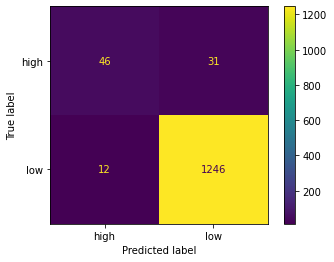

In [56]:
plot_confusion_mx(test_label, ripper_pred)

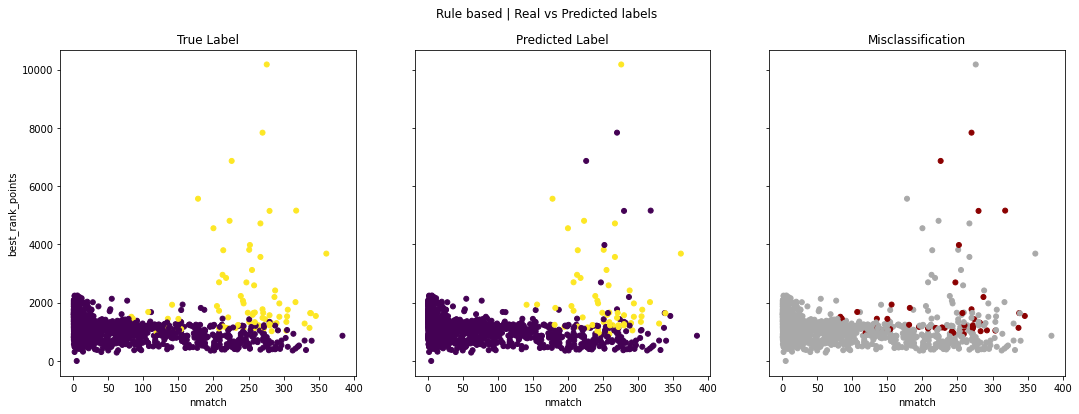

In [57]:
scatter_pred_data(test_set, test_label, ripper_pred, 'Rule based', 'nmatch', 'best_rank_points')

**prediction obtaining the used rules**

In [58]:
ripper_pred_reasons = ripper.predict(test_set, give_reasons=True)

In [59]:
indexes = [i for i,elem in enumerate(ripper_pred_reasons[0]) if elem == True]
rules_used = [ripper_pred_reasons[1][elem] for i,elem in enumerate(indexes)]

In [60]:
len(rules_used) #high predictions

58

In [61]:
rules_used

[[<Rule [bpS=>578.0^best_rank_points=1258.0-1401.0^tot_minutes=>20354.99]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [bpS=>578.0^best_rank_points=>1771.9]>],
 [<Rule [df=>443.6^best_rank_points=1213.0-1258.0]>],
 [<Rule [df=>443.6^best_rank_points=1213.0-1258.0]>],
 [<Rule [bpS=>578.0^best_rank_points=1139.0-1213.0]>,
  <Rule [df=>443.6^best_rank_points=1139.0-1213.0]>],
 [<Rule [sv1st=>6264.6^best_rank_points=1401.0-1771.9^tot_minutes=>20354.99]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [df=>443.6^sex_num=0^best_rank_points=>1771.9]>,
  <Rule [bpS=>578.0^best_rank_points=>1771.9]>,
  <Rule [df=>443.6^sex_num=0^sv1st_win=>4173.4^w_tourney=1.0-3.0]>,
  <Rule [best_rank_points=>1771.9^sex_num=0]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [df=>443.6^sex_num=0^best_rank_points=>1771.9]>,
  <Rule [bpS=>578.0^best_rank_points=>1771.9]>,
  <Rule [best_rank_points=>1771.9^sex_num=

### Gaussian Naive Bayes

**Importing libraries**

In [62]:
from sklearn.naive_bayes import GaussianNB

In [63]:
gnb_models = {}

**Define the model**

In [64]:
gnb_model = GaussianNB()

**Train the Gaussain Naive Bayes classifier**

In [65]:
gnb_model.fit(train_set, train_label)
gnb_models['gnb_original'] = gnb_model

In [66]:
train_pred = gnb_model.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.93      0.96      2934
        high       0.44      0.94      0.60       178

    accuracy                           0.93      3112
   macro avg       0.72      0.93      0.78      3112
weighted avg       0.96      0.93      0.94      3112



In [67]:
test_pred = gnb_model.predict(test_set)
print(classification_report(test_label, test_pred, target_names = ['low','high']))

              precision    recall  f1-score   support

         low       0.99      0.93      0.96      1258
        high       0.42      0.88      0.57        77

    accuracy                           0.92      1335
   macro avg       0.71      0.90      0.77      1335
weighted avg       0.96      0.92      0.94      1335



The performance report reveals the low capacity of the GNB classifier to correctly classify the hig rank players. This is due to the highly imbalanced dataset.

Let's plot the confusion matrix

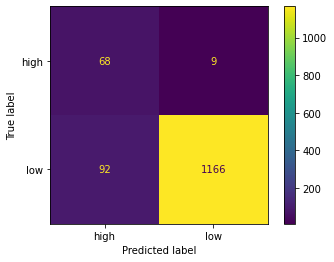

In [68]:
plot_confusion_mx(test_label, test_pred)

### AdaBoost
Adaboost is an ensemble learning algorithm that uses the boosting method.

In [69]:
# Setthe variables to make them easier to use
X_train, X_test, y_train, y_test = train_set.values, test_set.values, train_label.values, test_label.values

In [70]:
ab_models = {}

##### Using DecisionTreeClassifier (default) as Base Learners

In [71]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)
ab_models['ab_original'] = model 

In [72]:
#Predict the response for train dataset
X_pred = model.predict(X_train)

In [73]:
# Report score on train label
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       0.98      0.98      0.98       178

    accuracy                           1.00      3112
   macro avg       0.99      0.99      0.99      3112
weighted avg       1.00      1.00      1.00      3112



In [74]:
#Predict the response for test dataset
y_pred = model.predict(X_test)

In [75]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9790262172284644


In [76]:
# Report score on test label
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.81      0.83      0.82        77

    accuracy                           0.98      1335
   macro avg       0.90      0.91      0.90      1335
weighted avg       0.98      0.98      0.98      1335



##### Using Support Vector Classifier as Base Learners

In [77]:
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9423220973782771


In [78]:
# Report score on test label
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      1258
        high       0.00      0.00      0.00        77

    accuracy                           0.94      1335
   macro avg       0.47      0.50      0.49      1335
weighted avg       0.89      0.94      0.91      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [79]:
# Predict the response for train dataset
X_pred = model.predict(X_train)

In [80]:
# Report score on train label
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.94      3112
   macro avg       0.47      0.50      0.49      3112
weighted avg       0.89      0.94      0.92      3112



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Random Forest
Is a class of ensemble methods specifically designed for decision trees. It combines the predictions made by multiple decision trees and outputs the class that is the mode of the class's output by individual trees.

In [81]:
rf_models = {}
clf=RandomForestClassifier(n_estimators=100)
# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_set,train_label)
rf_models['rf_original'] = clf

In [82]:
# Predict the response for train dataset
X_pred = model.predict(X_train)

In [83]:
# Report score on train label
report_scores(train_label, X_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.94      3112
   macro avg       0.47      0.50      0.49      3112
weighted avg       0.89      0.94      0.92      3112



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [84]:
# Predict on test set
y_pred=clf.predict(test_set)

In [85]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_label, y_pred))

Accuracy: 0.9842696629213483


In [86]:
# Report score on test label
report_scores(test_label, y_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.90      0.82      0.86        77

    accuracy                           0.98      1335
   macro avg       0.94      0.91      0.92      1335
weighted avg       0.98      0.98      0.98      1335



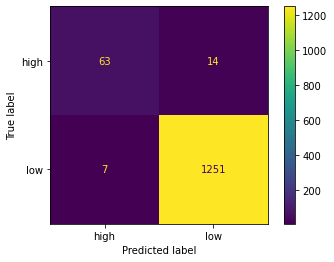

In [87]:
plot_confusion_mx(test_label, y_pred)

### Neural Networks

**Importing libraries**

In [88]:
import tensorflow as tf

2022-01-18 21:48:51.524833: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/jni:/usr/lib/i386-linux-gnu/jni/
2022-01-18 21:48:51.524854: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In the following list we will save all the trained Neural Network models. 

In [89]:
nn_models = {}

**Define and compile the neural network model.**

Function that returns the defalut neural network model with initial weights.

In [90]:
def base_nn_model(optimizer = 'adam', activation='relu', dropout_rate=0.15, neurons=15, loss='binary_crossentropy'): #specify parameters so that we can do grid search
    # create model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(1, len(train_set.columns))),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(neurons, activation=activation),
        tf.keras.layers.Dropout(dropout_rate),    
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # Compile model
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

Give a model and trainig set, this function train the neural network model.

Best: 0.973970 using {'activation': 'relu', 'batch_size': 500, 'dropout_rate': 0.2, 'epochs': 100, 'loss': 'binary_crossentropy', 'neurons': 13, 'optimizer': 'adam'}

In [91]:
def train_nn_model(model, train_set, train_label, epochs=60, batch_size=128,validation_split=0.2, verbose=False, class_weights=None):
    x_train = np.reshape(train_set.values, (len(train_set), 1, len(train_set.columns)))
    if class_weights is not None:
        history = model.fit(x_train, train_label,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=validation_split,
                    class_weight=class_weights,
                    verbose=verbose)
    else:
        history = model.fit(x_train, train_label,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_split=validation_split,
                            verbose=verbose)
    return model, history

In [92]:
nn_model = base_nn_model()
nn_model, history = train_nn_model(nn_model, norm_train_set, train_label)
nn_models['nn_original'] = nn_model

2022-01-18 21:48:54.866088: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-01-18 21:48:54.866114: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tars): /proc/driver/nvidia/version does not exist
2022-01-18 21:48:54.866707: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [93]:
nn_model, history = train_nn_model(nn_model, train_set, train_label)

Train the model using the original and normalized dataset.

In [94]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 15)                0         
                                                                 
 dense (Dense)               (None, 15)                240       
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable pa

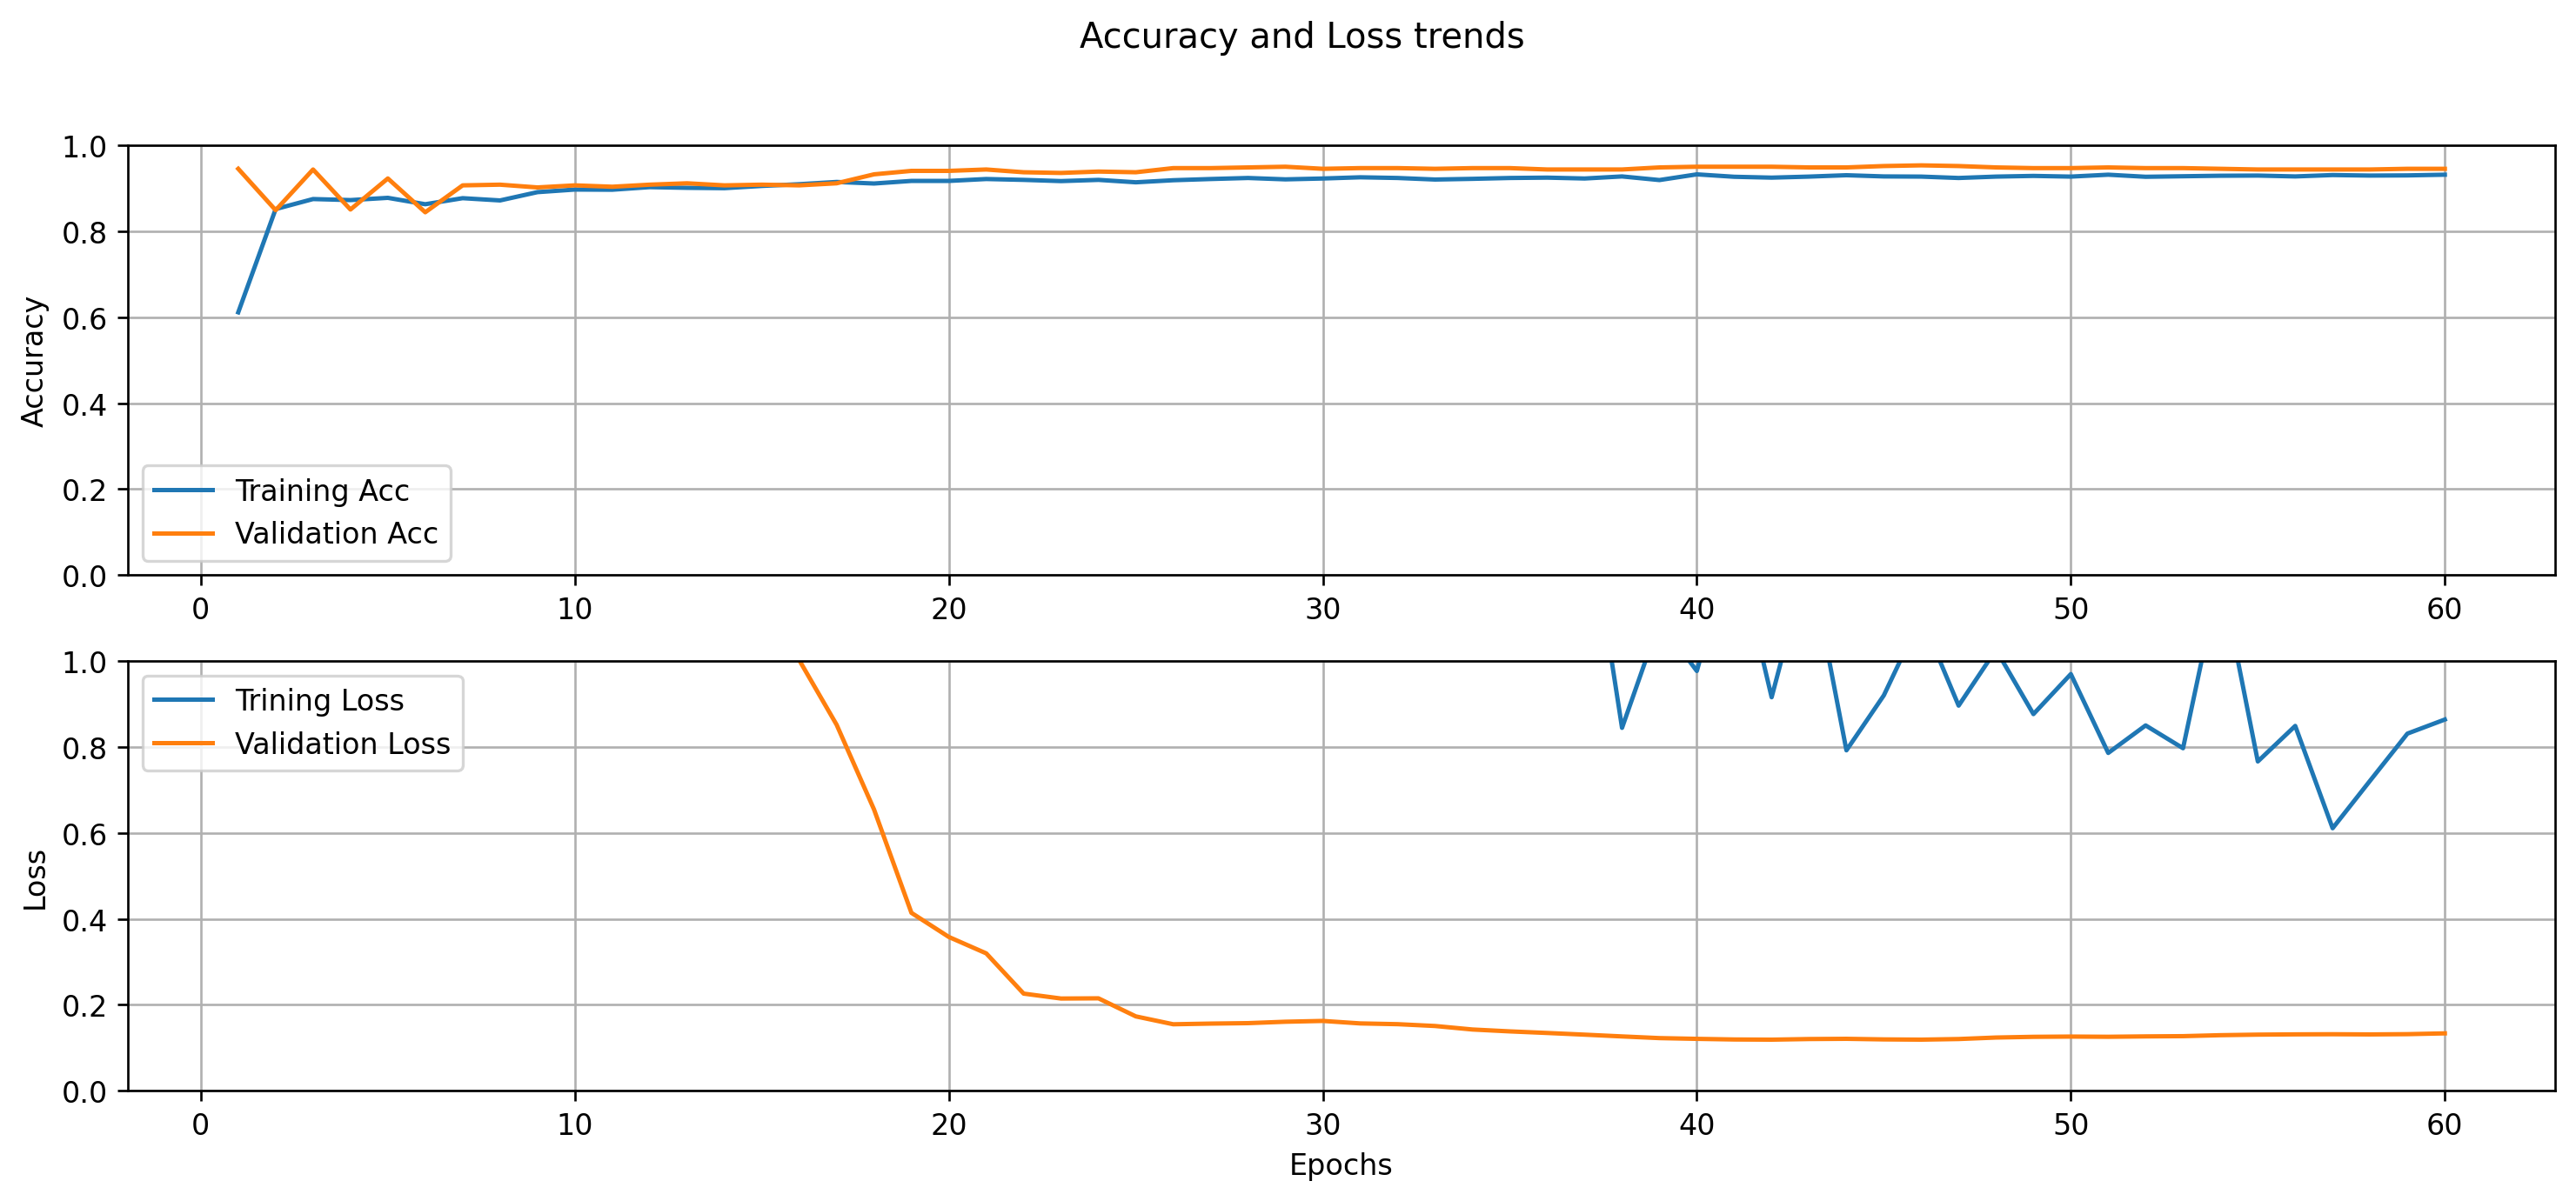

In [95]:
plot_nn_training_history(history)

In [96]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(train_set.columns)))
train_pred = (nn_model.predict(x_train_test) > 0.5).astype("int32")

In [97]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.94      3112
   macro avg       0.47      0.50      0.49      3112
weighted avg       0.89      0.94      0.92      3112



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [98]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model.predict(x_test) > 0.5).astype("int32")

In [99]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.94      1.00      0.97      1258
        high       0.00      0.00      0.00        77

    accuracy                           0.94      1335
   macro avg       0.47      0.50      0.49      1335
weighted avg       0.89      0.94      0.91      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Given the trained NN model, let's look the cofusion matrix on the test set

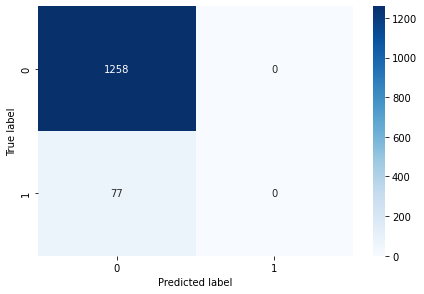

In [100]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

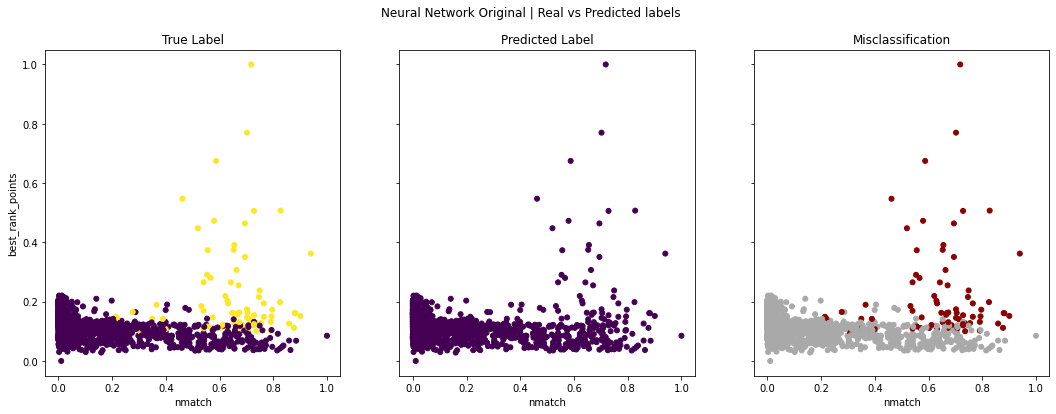

In [101]:
scatter_pred_data(norm_test_set, test_label, test_pred, 'Neural Network Original', 'nmatch', 'best_rank_points')

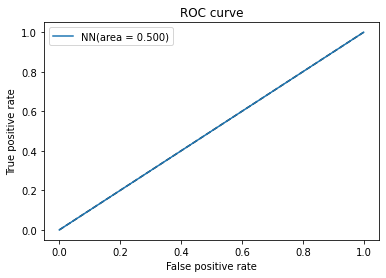

In [102]:
roc_curve_plot(nn_model, norm_test_set, test_label, 'NN')

### KNN (K-Nearest Neighbors)

In [103]:
from sklearn.neighbors import KNeighborsClassifier

In [104]:
knn_models = {}

Fit and scoring the classifier using the function *GridSearchCV*, by sklearn, that automatically compute the best combination of parameters for the model training. Below are created the set of parameters for the KNN training that the function will use.

For the KNN we need to remove the categorical attributes.

In [105]:
knn_train_set = train_set.drop(columns=['sex_num', 'hand_num'])
knn_test_set = test_set.drop(columns=['sex_num', 'hand_num'])

In [106]:
k_range = range(1,31)

In [107]:
knn_metrics = ['euclidean', 'manhattan']

In [108]:
knn_weights = ['uniform', 'distance']

In [109]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

In [110]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [111]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(knn_train_set, train_label)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [112]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9765427900074203
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}


In [113]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(knn_train_set, train_label)

In [114]:
knn_models['knn_original'] = knn

In [115]:
train_pred = knn.predict(knn_train_set)
report_scores(train_label,train_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.99      2934
        high       0.89      0.70      0.78       178

    accuracy                           0.98      3112
   macro avg       0.93      0.85      0.88      3112
weighted avg       0.98      0.98      0.98      3112



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [116]:
test_pred = knn.predict(knn_test_set)
report_scores(test_label,test_pred)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         low       0.98      1.00      0.99      1258
        high       0.90      0.60      0.72        77

    accuracy                           0.97      1335
   macro avg       0.94      0.80      0.85      1335
weighted avg       0.97      0.97      0.97      1335



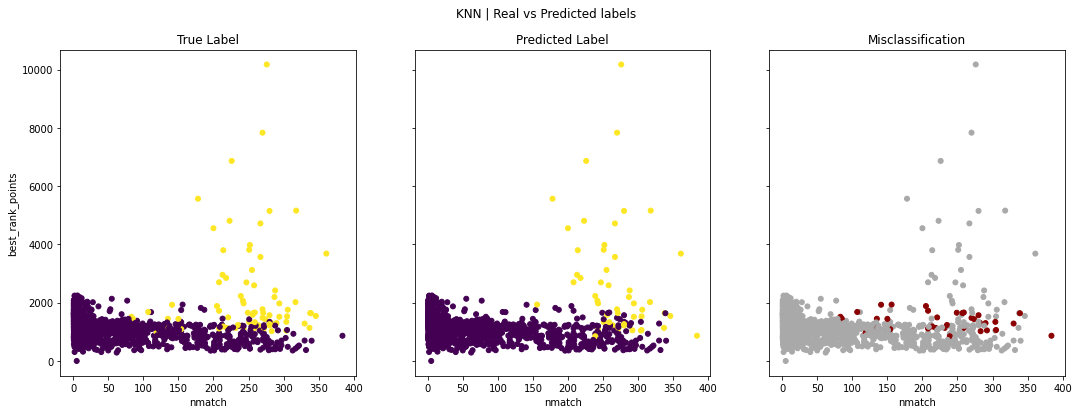

In [117]:
scatter_pred_data(test_set, test_label, test_pred, 'KNN', 'nmatch', 'best_rank_points')

As we know from the theory, the nearest neighbor classifiers can be biased by noise points that have oversized data values that can miss lead the classification task. The solution to this problem is normalization, in the following lines of code a normalized dataset is created using the *MinMaxScaler*

In [118]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
norm_knn_train_set = normalize_dataset(knn_train_set)
norm_knn_test_set = normalize_dataset(knn_test_set)
knn_grid.fit(norm_knn_train_set, train_label)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [119]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9713991260615055
Parameters: {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}


In [120]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(norm_knn_train_set, train_label)

In [121]:
train_pred = knn.predict(norm_knn_train_set)
report_scores(train_label,train_pred)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       178

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112



In [122]:
test_pred = knn.predict(norm_knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.98      0.98      1258
        high       0.74      0.73      0.73        77

    accuracy                           0.97      1335
   macro avg       0.86      0.86      0.86      1335
weighted avg       0.97      0.97      0.97      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


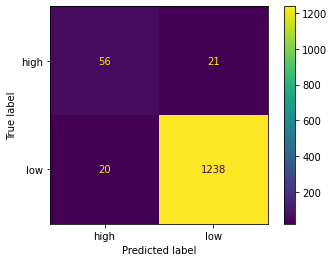

In [123]:
plot_confusion_mx(test_label, test_pred)

# Classification with weights

Weights associated with classes in the form {class_label: weight}.

The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as:

$\frac{n_{samples}}{(n_{classes}\  *\  np.bincount(y))}$

Using weights we can say that the examples of a given class are more important than examples of the other class. <br>
To find the best weights for each classifier we do a grid search on a given list of weights.

In [124]:
#set weights
weights = {0:1.0, 1:100.0} #0=low, 1 = high
balance = [{0:0.8,1:3.5}, {0:1,1:5}, {0:1,1:10}, {0:1,1:15}, {0:1,1:20}, {0:1,1:50}, {0:1,1:100}, 'balanced']

### Decision tree

**creation of the model**

In [125]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight=weights)
dt = dt.fit(train_set, train_label)

#### choise of weights

In [126]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [127]:
grid_result = grid_search.fit(train_set, train_label)

In [128]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.978226 using {'class_weight': {0: 1, 1: 100}}
0.970273 (0.026207) with: {'class_weight': {0: 0.8, 1: 3.5}}
0.965172 (0.026540) with: {'class_weight': {0: 1, 1: 5}}
0.971824 (0.023231) with: {'class_weight': {0: 1, 1: 10}}
0.968055 (0.026571) with: {'class_weight': {0: 1, 1: 15}}
0.968318 (0.027447) with: {'class_weight': {0: 1, 1: 20}}
0.978019 (0.021666) with: {'class_weight': {0: 1, 1: 50}}
0.978226 (0.018150) with: {'class_weight': {0: 1, 1: 100}}
0.968071 (0.027461) with: {'class_weight': 'balanced'}


In [129]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5, class_weight=grid_result.best_params_['class_weight'])
dt = dt.fit(train_set, train_label)
dt_models['dt_weighted'] = dt

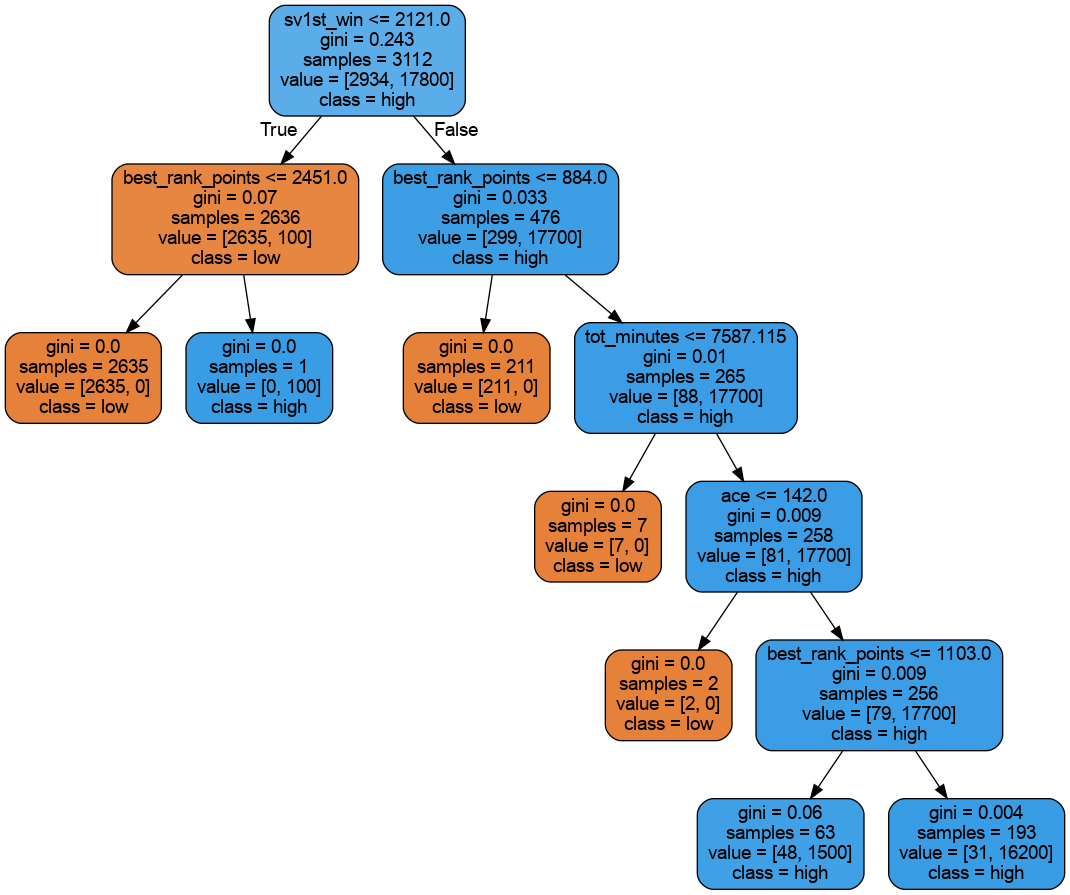

In [130]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['low', 'high'],  #[0, 1]
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

**prediction**

In [131]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

**evaluation**

In [132]:
report_scores(train_label, train_pred_dt)

              precision    recall  f1-score   support

         low       1.00      0.97      0.99      2934
        high       0.69      1.00      0.82       178

    accuracy                           0.97      3112
   macro avg       0.85      0.99      0.90      3112
weighted avg       0.98      0.97      0.98      3112



In [133]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.70      0.90      0.79        77

    accuracy                           0.97      1335
   macro avg       0.85      0.94      0.89      1335
weighted avg       0.98      0.97      0.97      1335



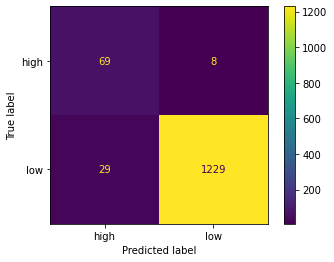

In [134]:
plot_confusion_mx(test_label, test_pred_dt)

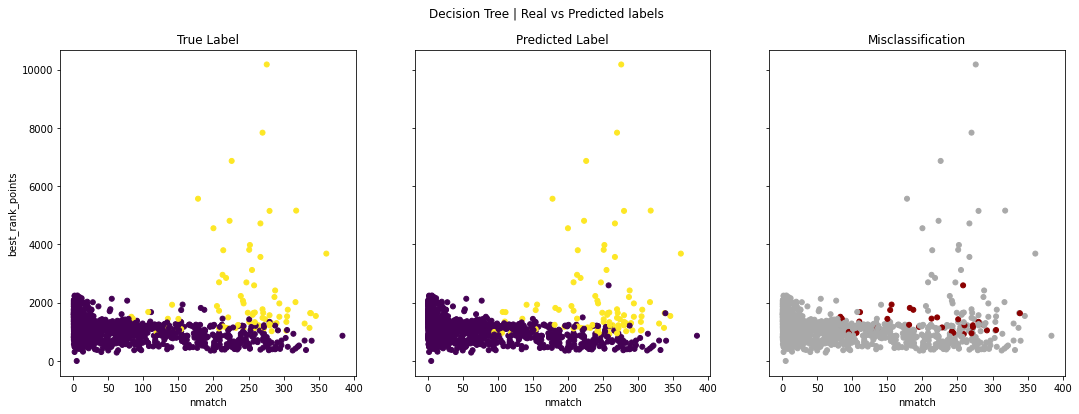

In [135]:
scatter_pred_data(test_set, test_label, test_pred_dt, 'Decision Tree', 'nmatch', 'best_rank_points')

### SVM

**creation of the model with fixed weights**

In [136]:
svm = SVC(gamma='scale', class_weight=weights)
svm.fit(train_set, train_label)

SVC(class_weight={0: 1.0, 1: 100.0})

In [137]:
train_pred = svm.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.91      0.95      2934
        high       0.41      1.00      0.58       178

    accuracy                           0.92      3112
   macro avg       0.70      0.96      0.77      3112
weighted avg       0.97      0.92      0.93      3112



In [138]:
test_pred = svm.predict(test_set)

In [139]:
#compute the performance of the model
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      0.91      0.95      1258
        high       0.40      0.99      0.57        77

    accuracy                           0.91      1335
   macro avg       0.70      0.95      0.76      1335
weighted avg       0.96      0.91      0.93      1335



#### choise of weights

In [140]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

In [141]:
grid_result = grid_search.fit(train_set, train_label)

In [142]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.993244 using {'class_weight': {0: 1, 1: 15}}
0.992472 (0.003803) with: {'class_weight': {0: 0.8, 1: 3.5}}
0.993017 (0.003761) with: {'class_weight': {0: 1, 1: 5}}
0.993016 (0.003521) with: {'class_weight': {0: 1, 1: 10}}
0.993244 (0.003616) with: {'class_weight': {0: 1, 1: 15}}
0.993087 (0.003591) with: {'class_weight': {0: 1, 1: 20}}
0.992766 (0.004264) with: {'class_weight': {0: 1, 1: 50}}
0.991499 (0.006118) with: {'class_weight': {0: 1, 1: 100}}
0.992679 (0.003856) with: {'class_weight': 'balanced'}


In [143]:
svm = SVC(gamma='scale', class_weight=grid_result.best_params_['class_weight'])
svm.fit(train_set, train_label)
svm_models['svm_weighted'] = svm

**prediction and evaluation**

In [144]:
train_pred = svm.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.94      0.97      2934
        high       0.49      0.98      0.66       178

    accuracy                           0.94      3112
   macro avg       0.75      0.96      0.81      3112
weighted avg       0.97      0.94      0.95      3112



In [145]:
test_pred = svm.predict(test_set)
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      0.94      0.97      1258
        high       0.47      0.95      0.63        77

    accuracy                           0.94      1335
   macro avg       0.74      0.94      0.80      1335
weighted avg       0.97      0.94      0.95      1335



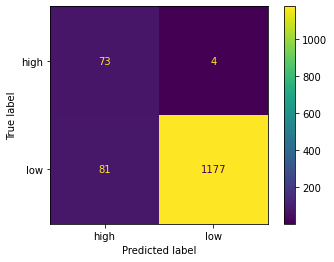

In [146]:
plot_confusion_mx(test_label, test_pred)

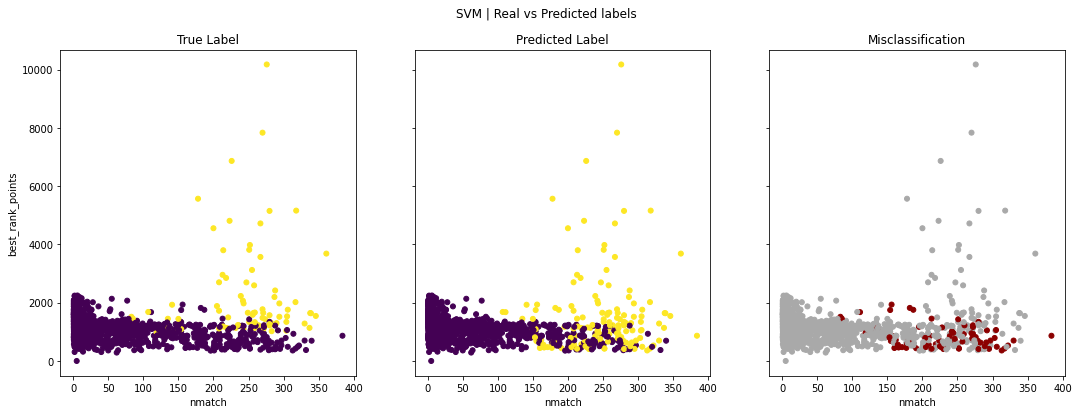

In [147]:
scatter_pred_data(test_set, test_label, test_pred, 'SVM', 'nmatch', 'best_rank_points')

### Rule based

**creation of the model and choose of weights and parameters**

In [148]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5], "class_weight": balance}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)

In [149]:
grid_result = grid_search.fit(train_set, train_label, pos_class=1)
grid_result.best_params_

{'class_weight': {0: 0.8, 1: 3.5}, 'k': 5, 'prune_size': 0.5}

In [150]:
ripper = lw.RIPPER(k=grid_result.best_params_['k'], prune_size=grid_result.best_params_['prune_size'])
datas = pd.concat([train_set, train_label], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1, class_weight = grid_result.best_params_['class_weight'])

**get model (rules)**

In [151]:
#in this case the model is a set of rules
ripper.out_model()

[[bpS=>578.0 ^ best_rank_points=>1771.9 ^ tot_minutes=>20354.99] V
[df=>443.6 ^ best_rank_points=1139.0-1213.0] V
[sv1st=>6264.6 ^ best_rank_points=1401.0-1771.9] V
[bpS=>578.0 ^ sex_num=0 ^ best_rank_points=>1771.9] V
[sv2nd_win=>1923.9 ^ sex_num=0 ^ best_rank_points=1258.0-1401.0] V
[df=>443.6 ^ best_rank_points=>1771.9 ^ bpS=191.0-578.0] V
[sv1st=>6264.6 ^ best_rank_points=1042.4-1139.0 ^ hand_num=0] V
[sv1st=>6264.6 ^ best_rank_points=927.0-1042.4 ^ wmatch=81.0-128.0] V
[sv1st=>6264.6 ^ best_rank_points=>1771.9 ^ lmatch=46.0-70.0] V
[sv1st_win=>4173.4 ^ best_rank_points=1258.0-1401.0 ^ tot_minutes=>20354.99] V
[bpS=>578.0 ^ best_rank_points=1139.0-1213.0] V
[sv1st_win=1303.0-4173.4 ^ best_rank_points=>1771.9 ^ sex_num=0] V
[ace=>470.0 ^ best_rank_points=1042.4-1139.0 ^ n_tourney=>106.0] V
[df=>443.6 ^ best_rank_points=1213.0-1258.0 ^ w_tourney=>3.0]]


In [152]:
rb_models['rb_weighted'] = ripper

**prediction and evaluation**

In [153]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       0.98      1.00      0.99      2934
        high       0.94      0.60      0.73       178

    accuracy                           0.97      3112
   macro avg       0.96      0.80      0.86      3112
weighted avg       0.97      0.97      0.97      3112



In [154]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.85      0.60      0.70        77

    accuracy                           0.97      1335
   macro avg       0.91      0.80      0.84      1335
weighted avg       0.97      0.97      0.97      1335



In [155]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9707865168539326
Precision  0.8518518518518519
Recall  0.5974025974025974


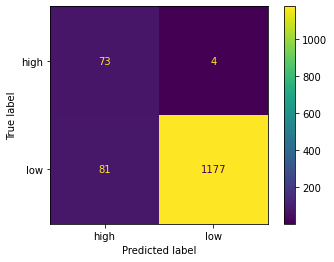

In [156]:
plot_confusion_mx(test_label, test_pred)

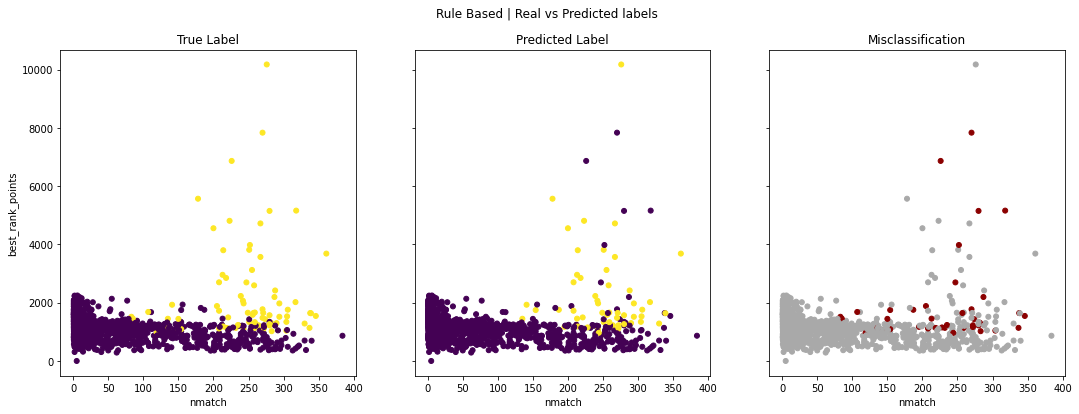

In [157]:
scatter_pred_data(test_set, test_label, ripper_pred, 'Rule Based', 'nmatch', 'best_rank_points')

**rules used for predictions**

In [158]:
ripper_pred_reasons = ripper.predict(test_set, give_reasons=True)

In [159]:
indexes = [i for i,elem in enumerate(ripper_pred_reasons[0]) if elem == True]
rules_used = [ripper_pred_reasons[1][elem] for i,elem in enumerate(indexes)]
rules_used

[[<Rule [sv2nd_win=>1923.9^sex_num=0^best_rank_points=1258.0-1401.0]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>],
 [<Rule [df=>443.6^best_rank_points=1213.0-1258.0^w_tourney=>3.0]>],
 [<Rule [df=>443.6^best_rank_points=1213.0-1258.0^w_tourney=>3.0]>],
 [<Rule [df=>443.6^best_rank_points=1139.0-1213.0]>,
  <Rule [bpS=>578.0^best_rank_points=1139.0-1213.0]>],
 [<Rule [sv1st=>6264.6^best_rank_points=1401.0-1771.9]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [bpS=>578.0^sex_num=0^best_rank_points=>1771.9]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [bpS=>578.0^sex_num=0^best_rank_points=>1771.9]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>,
  <Rule [bpS=>578.0^sex_num=0^best_rank_points=>1771.9]>],
 [<Rule [bpS=>578.0^best_rank_points=>1771.9^tot_minutes=>20354.99]>],
 [<Rule [sv1st=>6264.6^best_rank_points=1401.0-1771.9]>],
 [<Rule [df=>443.6^best_rank_points=1

### Neural Networks

Now let's re-run the neural network classifier using the weighted classes.

#### choise of weights

In [160]:
from sklearn.utils import class_weight
weights_nn = {0: 0.75, 1: 3.5}
class_weights = class_weight.compute_class_weight(class_weight = weights_nn,
                                                 classes = np.unique(train_label),
                                                 y = train_label)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.75, 1: 3.5}


In [161]:
nn_model_w = base_nn_model()
nn_model_w, history = train_nn_model(nn_model_w, norm_train_set, train_label)
nn_models['nn_weighted'] = nn_model_w

Train the model using the original and normalized dataset.

In [162]:
nn_model_w.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 15)                0         
                                                                 
 dense_3 (Dense)             (None, 15)                240       
                                                                 
 dropout_2 (Dropout)         (None, 15)                0         
                                                                 
 dense_4 (Dense)             (None, 15)                240       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable 

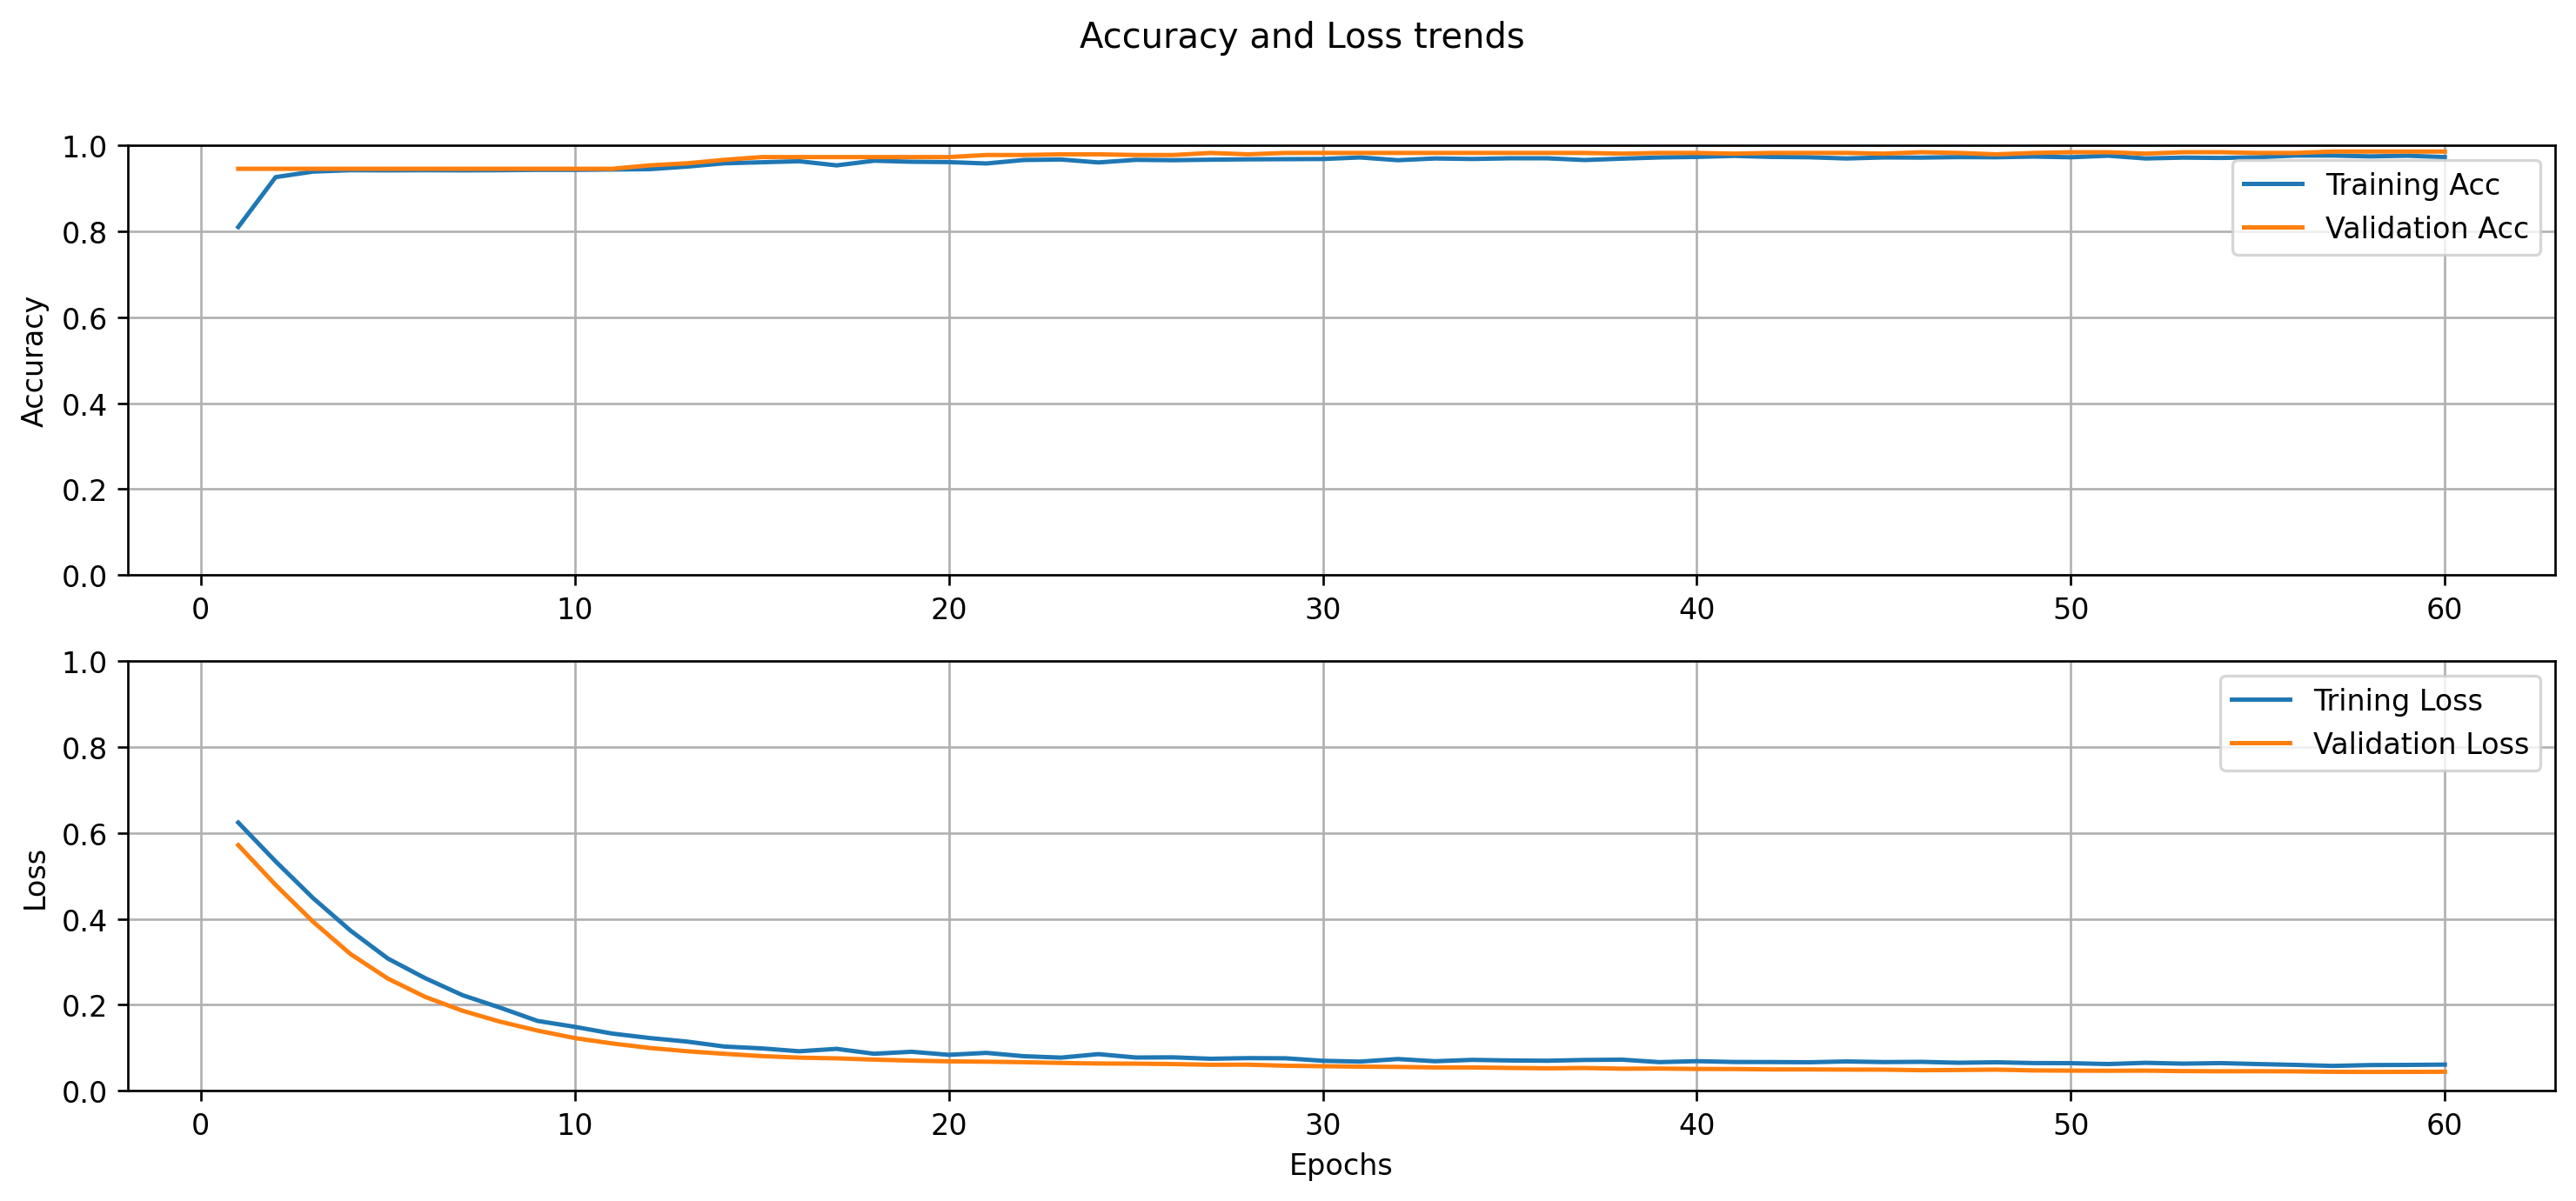

In [163]:
plot_nn_training_history(history)

In [164]:
x_train_test = np.reshape(norm_train_set.values, (len(norm_train_set), 1, len(norm_train_set.columns)))
train_pred = (nn_model_w.predict(x_train_test) > 0.5).astype("int32")

In [165]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      2934
        high       0.89      0.76      0.82       178

    accuracy                           0.98      3112
   macro avg       0.94      0.88      0.91      3112
weighted avg       0.98      0.98      0.98      3112



In [166]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model_w.predict(x_test) > 0.5).astype("int32")

In [167]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.76      0.83      0.80        77

    accuracy                           0.98      1335
   macro avg       0.88      0.91      0.89      1335
weighted avg       0.98      0.98      0.98      1335



Given the trained NN model, let's look the cofusion matrix on the test set

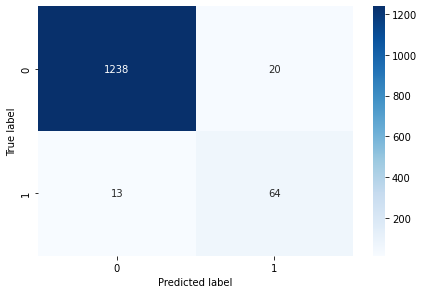

In [168]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

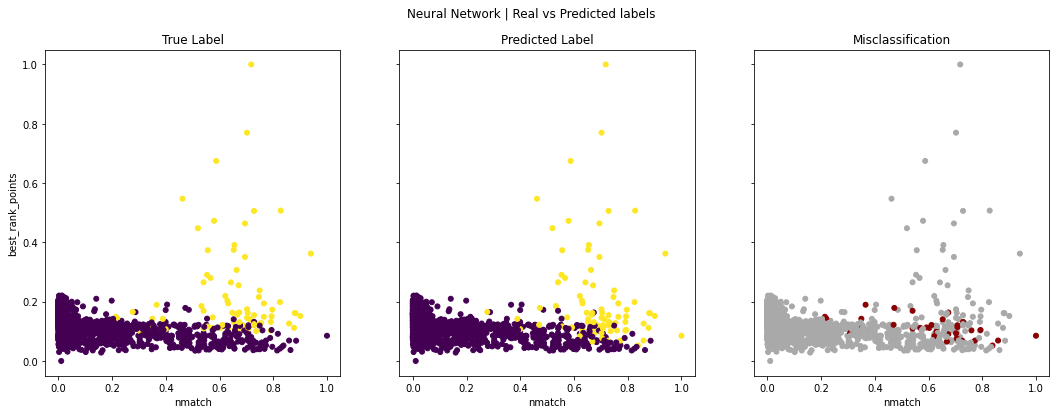

In [169]:
scatter_pred_data(norm_test_set, test_label, test_pred, 'Neural Network', 'nmatch', 'best_rank_points')

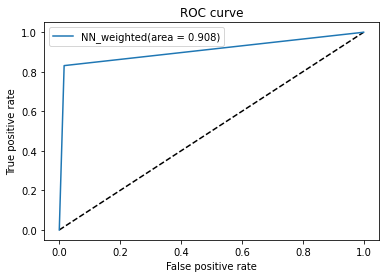

In [170]:
roc_curve_plot(nn_model_w, norm_test_set, test_label, 'NN_weighted')

### Random Forest

Now let's re-run the Random Forest classifier using the weighted classes.

In [171]:
clf=RandomForestClassifier(n_estimators=100, class_weight=None)
# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(train_set,train_label)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
param_grid = dict(class_weight=balance)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')

grid_result = grid_search.fit(train_set, train_label)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
clf=RandomForestClassifier(n_estimators=100, class_weight=grid_result.best_params_['class_weight'])

clf.fit(train_set,train_label)

y_pred=clf.predict(test_set)


train_pred = clf.predict(train_set)
report_scores(train_label, train_pred)

test_pred = clf.predict(test_set)
report_scores(test_label, test_pred)

Best: 0.997358 using {'class_weight': {0: 0.8, 1: 3.5}}
0.997358 (0.001547) with: {'class_weight': {0: 0.8, 1: 3.5}}
0.997298 (0.001627) with: {'class_weight': {0: 1, 1: 5}}
0.997274 (0.001679) with: {'class_weight': {0: 1, 1: 10}}
0.997222 (0.001525) with: {'class_weight': {0: 1, 1: 15}}
0.997153 (0.001467) with: {'class_weight': {0: 1, 1: 20}}
0.995870 (0.005188) with: {'class_weight': {0: 1, 1: 50}}
0.994062 (0.008601) with: {'class_weight': {0: 1, 1: 100}}
0.997002 (0.001759) with: {'class_weight': 'balanced'}
              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       178

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.87      0.84      0.86 

# Oversampling with SMOTE

We use SMOTE to apply oversampling to the 2 classes in the training set.

In [172]:
oversample = SMOTE(sampling_strategy=0.3)
training, labels = oversample.fit_resample(train_set, train_label)

**Original Dataset**

In [173]:
print_dataset_composition(train_set, train_label, test_set, test_label)

3112 training samples:
	- 2934 samples for the class Low Rank
	- 178 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


**Dataset after oversampling**

In [174]:
print_dataset_composition(training, labels, test_set, test_label)

3814 training samples:
	- 2934 samples for the class Low Rank
	- 880 samples for the class High Rank

1335 test samples:
	- 1258 samples for the class Low Rank
	- 77 samples for the class High Rank


### Decision tree

**new model**

In [175]:
dt = tree.DecisionTreeClassifier(criterion='gini', splitter='best', 
                                  max_depth=5)
dt = dt.fit(training, labels)
dt_models['dt_ov'] = dt

**prediction**

In [176]:
train_pred = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

**evaluation**

In [177]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.99      0.99      2934
        high       0.87      0.98      0.92       178

    accuracy                           0.99      3112
   macro avg       0.93      0.99      0.96      3112
weighted avg       0.99      0.99      0.99      3112



In [178]:
report_scores(test_label, test_pred_dt)

              precision    recall  f1-score   support

         low       1.00      0.99      0.99      1258
        high       0.80      0.92      0.86        77

    accuracy                           0.98      1335
   macro avg       0.90      0.95      0.92      1335
weighted avg       0.98      0.98      0.98      1335



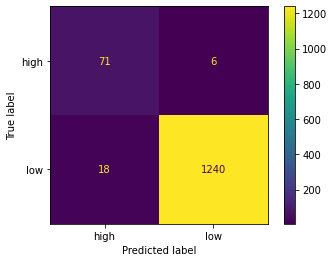

In [179]:
plot_confusion_mx(test_label, test_pred_dt)

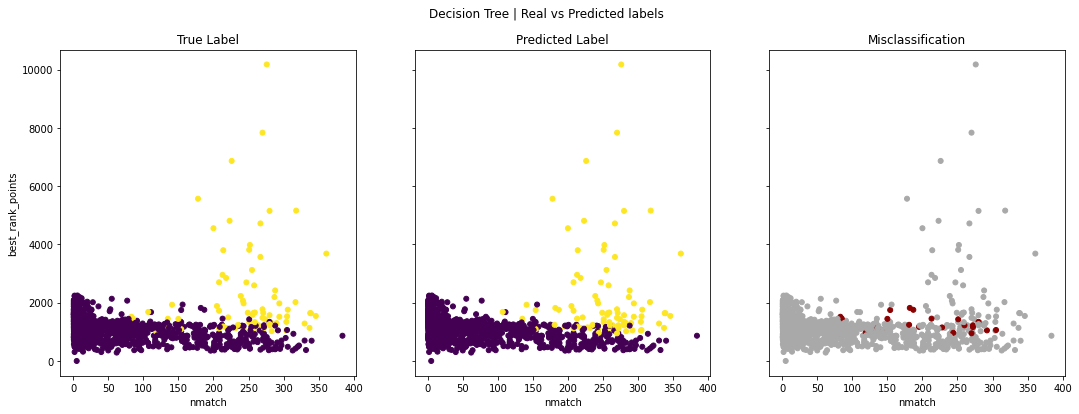

In [180]:
scatter_pred_data(test_set, test_label, test_pred_dt, 'Decision Tree', 'nmatch', 'best_rank_points')

### SVM

**new model**

In [181]:
svm = SVC(kernel='sigmoid', gamma='scale')
svm.fit(training, labels)
svm_models['svm_ov'] = svm 

**prediction**

In [182]:
train_pred = svm.predict(train_set)
test_pred = svm.predict(test_set)

**evaluation**

In [183]:
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       0.94      0.75      0.84      2934
        high       0.04      0.17      0.07       178

    accuracy                           0.72      3112
   macro avg       0.49      0.46      0.45      3112
weighted avg       0.89      0.72      0.79      3112



In [184]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.93      0.76      0.84      1258
        high       0.03      0.13      0.05        77

    accuracy                           0.73      1335
   macro avg       0.48      0.45      0.45      1335
weighted avg       0.88      0.73      0.79      1335



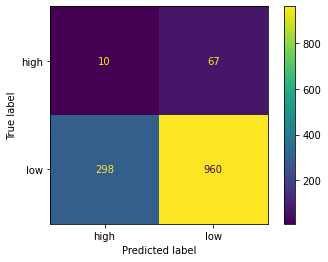

In [185]:
plot_confusion_mx(test_label, test_pred)

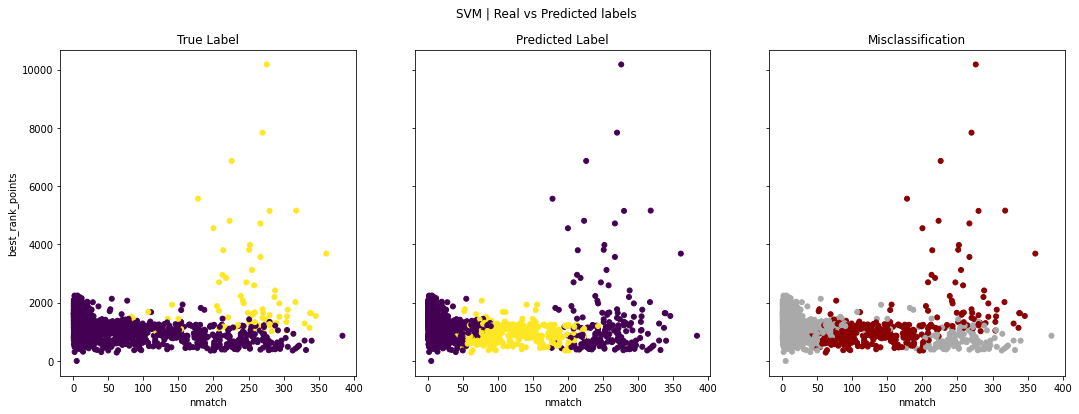

In [186]:
scatter_pred_data(test_set, test_label, test_pred, 'SVM', 'nmatch', 'best_rank_points')

### Rule based

**new model**

In [187]:
#we run a grid search to find the best configuration of parameters' values
ripper = lw.RIPPER()
param_grid = {"prune_size": [0.5, 0.6], "k": [1, 3, 5]}
grid_search = GridSearchCV(estimator=ripper, param_grid=param_grid)

In [188]:
grid_result = grid_search.fit(training, labels, pos_class=1)
grid_result.best_params_

{'k': 1, 'prune_size': 0.5}

In [189]:
ripper = lw.RIPPER(k=grid_result.best_params_['k'], prune_size=grid_result.best_params_['prune_size'])
datas = pd.concat([training, labels], axis=1)
ripper.fit(datas, class_feat='ranked', pos_class=1)

**model (rules)**

In [190]:
#in this case the model is a set of rules
ripper.out_model()

[[best_rank_points=>2285.3] V
[bpS=698.89-1051.26 ^ sex_num=0 ^ lmatch=100.0-122.0] V
[sv1st=>11805.7 ^ wmatch=129.0-158.0 ^ sv2nd_win=>3665.4 ^ ace=>1086.85] V
[lmatch=>122.0 ^ hand_num=0 ^ best_rank_points=1410.1-1740.8] V
[bpS=>1051.26 ^ best_rank_points=1740.8-2285.3] V
[bpS=698.89-1051.26 ^ sex_num=0 ^ sv2nd_win=2350.6-3665.4] V
[sv1st=3551.2-7644.4 ^ sex_num=0 ^ best_rank_points=1740.8-2285.3] V
[ace=562.0-1086.85 ^ hand_num=0 ^ best_rank_points=853.0-997.9] V
[bpS=>1051.26 ^ sex_num=0] V
[ace=562.0-1086.85 ^ w_tourney=3.0-5.0 ^ sv1st_win=>8181.7] V
[bpS=698.89-1051.26 ^ lmatch=75.0-100.0 ^ best_rank_points=1740.8-2285.3] V
[sv1st_win=>8181.7 ^ n_tourney=105.0-127.0] V
[ace=562.0-1086.85 ^ best_rank_points=997.9-1123.0 ^ tot_minutes=15450.7-21516.57] V
[sv2nd_win=>3665.4 ^ best_rank_points=997.9-1123.0] V
[bpS=698.89-1051.26 ^ best_rank_points=1410.1-1740.8] V
[ace=562.0-1086.85 ^ w_tourney=2.0-3.0 ^ best_rank_points=853.0-997.9] V
[sv2nd_win=>3665.4 ^ best_rank_points=1410.1-174

In [191]:
rb_models['rb_ov'] = ripper

**prediction and evaluation**

In [192]:
ripper_pred_train = ripper.predict(train_set)
report_scores(train_label, ripper_pred_train)

              precision    recall  f1-score   support

         low       1.00      0.99      0.99      2934
        high       0.86      0.94      0.90       178

    accuracy                           0.99      3112
   macro avg       0.93      0.96      0.95      3112
weighted avg       0.99      0.99      0.99      3112



In [193]:
ripper_pred = ripper.predict(test_set)
report_scores(test_label, ripper_pred)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.73      0.86      0.79        77

    accuracy                           0.97      1335
   macro avg       0.86      0.92      0.89      1335
weighted avg       0.98      0.97      0.97      1335



In [194]:
#evaluation of the performance of the classifier
print('Accuracy ', ripper.score(test_set, test_label))
print('Precision ', ripper.score(test_set, test_label, precision_score))
print('Recall ', ripper.score(test_set, test_label, recall_score))

Accuracy  0.9730337078651685
Precision  0.7252747252747253
Recall  0.8571428571428571


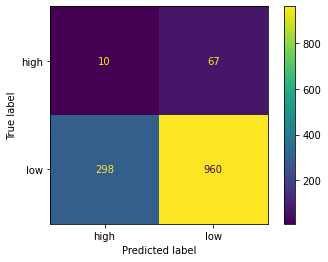

In [195]:
plot_confusion_mx(test_label, test_pred)

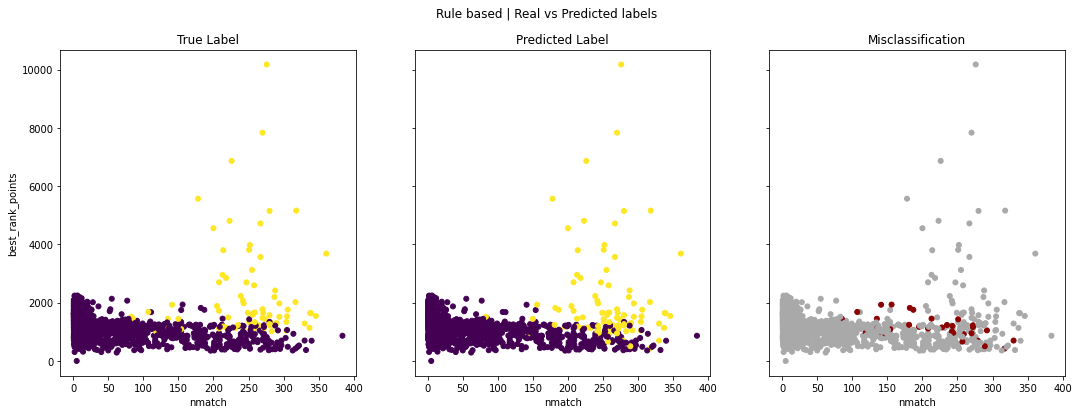

In [196]:
scatter_pred_data(test_set, test_label, ripper_pred, 'Rule based', 'nmatch', 'best_rank_points')

### Gaussain Naive Bayes

Gaussain Naive Bayes using the oversampled dataset.

**Define the model**

In [197]:
gnb_model = GaussianNB()

**Train the Gaussain Naive Bayes classifier**

In [198]:
gnb_model.fit(training, labels)
gnb_models['gnb_ov'] = gnb_model

In [199]:
train_pred = gnb_model.predict(train_set)
report_scores(train_label, train_pred)

              precision    recall  f1-score   support

         low       1.00      0.92      0.96      2934
        high       0.43      0.94      0.59       178

    accuracy                           0.93      3112
   macro avg       0.71      0.93      0.78      3112
weighted avg       0.96      0.93      0.94      3112



In [200]:
test_pred = gnb_model.predict(test_set)
print(classification_report(test_label, test_pred, target_names = ['low','high']))

              precision    recall  f1-score   support

         low       0.99      0.92      0.96      1258
        high       0.42      0.91      0.57        77

    accuracy                           0.92      1335
   macro avg       0.71      0.92      0.77      1335
weighted avg       0.96      0.92      0.94      1335



The performance report reveals the low capacity of the GNB classifier to correctly classify the hig rank players. This is due to the highly imbalanced dataset.

Let's plot the confusion matrix

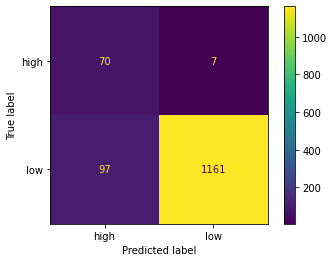

In [201]:
plot_confusion_mx(test_label,test_pred)
plt.show() 

### Neural Networks

In [202]:
norm_ov_train_set = normalize_dataset(training)

In [203]:
nn_model_ov = base_nn_model()
nn_model_ov, history = train_nn_model(nn_model_ov, norm_ov_train_set, labels)
nn_models['nn_ov'] = nn_model_ov

In [204]:
nn_model_ov.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 dense_6 (Dense)             (None, 15)                240       
                                                                 
 dropout_4 (Dropout)         (None, 15)                0         
                                                                 
 dense_7 (Dense)             (None, 15)                240       
                                                                 
 dropout_5 (Dropout)         (None, 15)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 16        
                                                                 
Total params: 496
Trainable params: 496
Non-trainable 

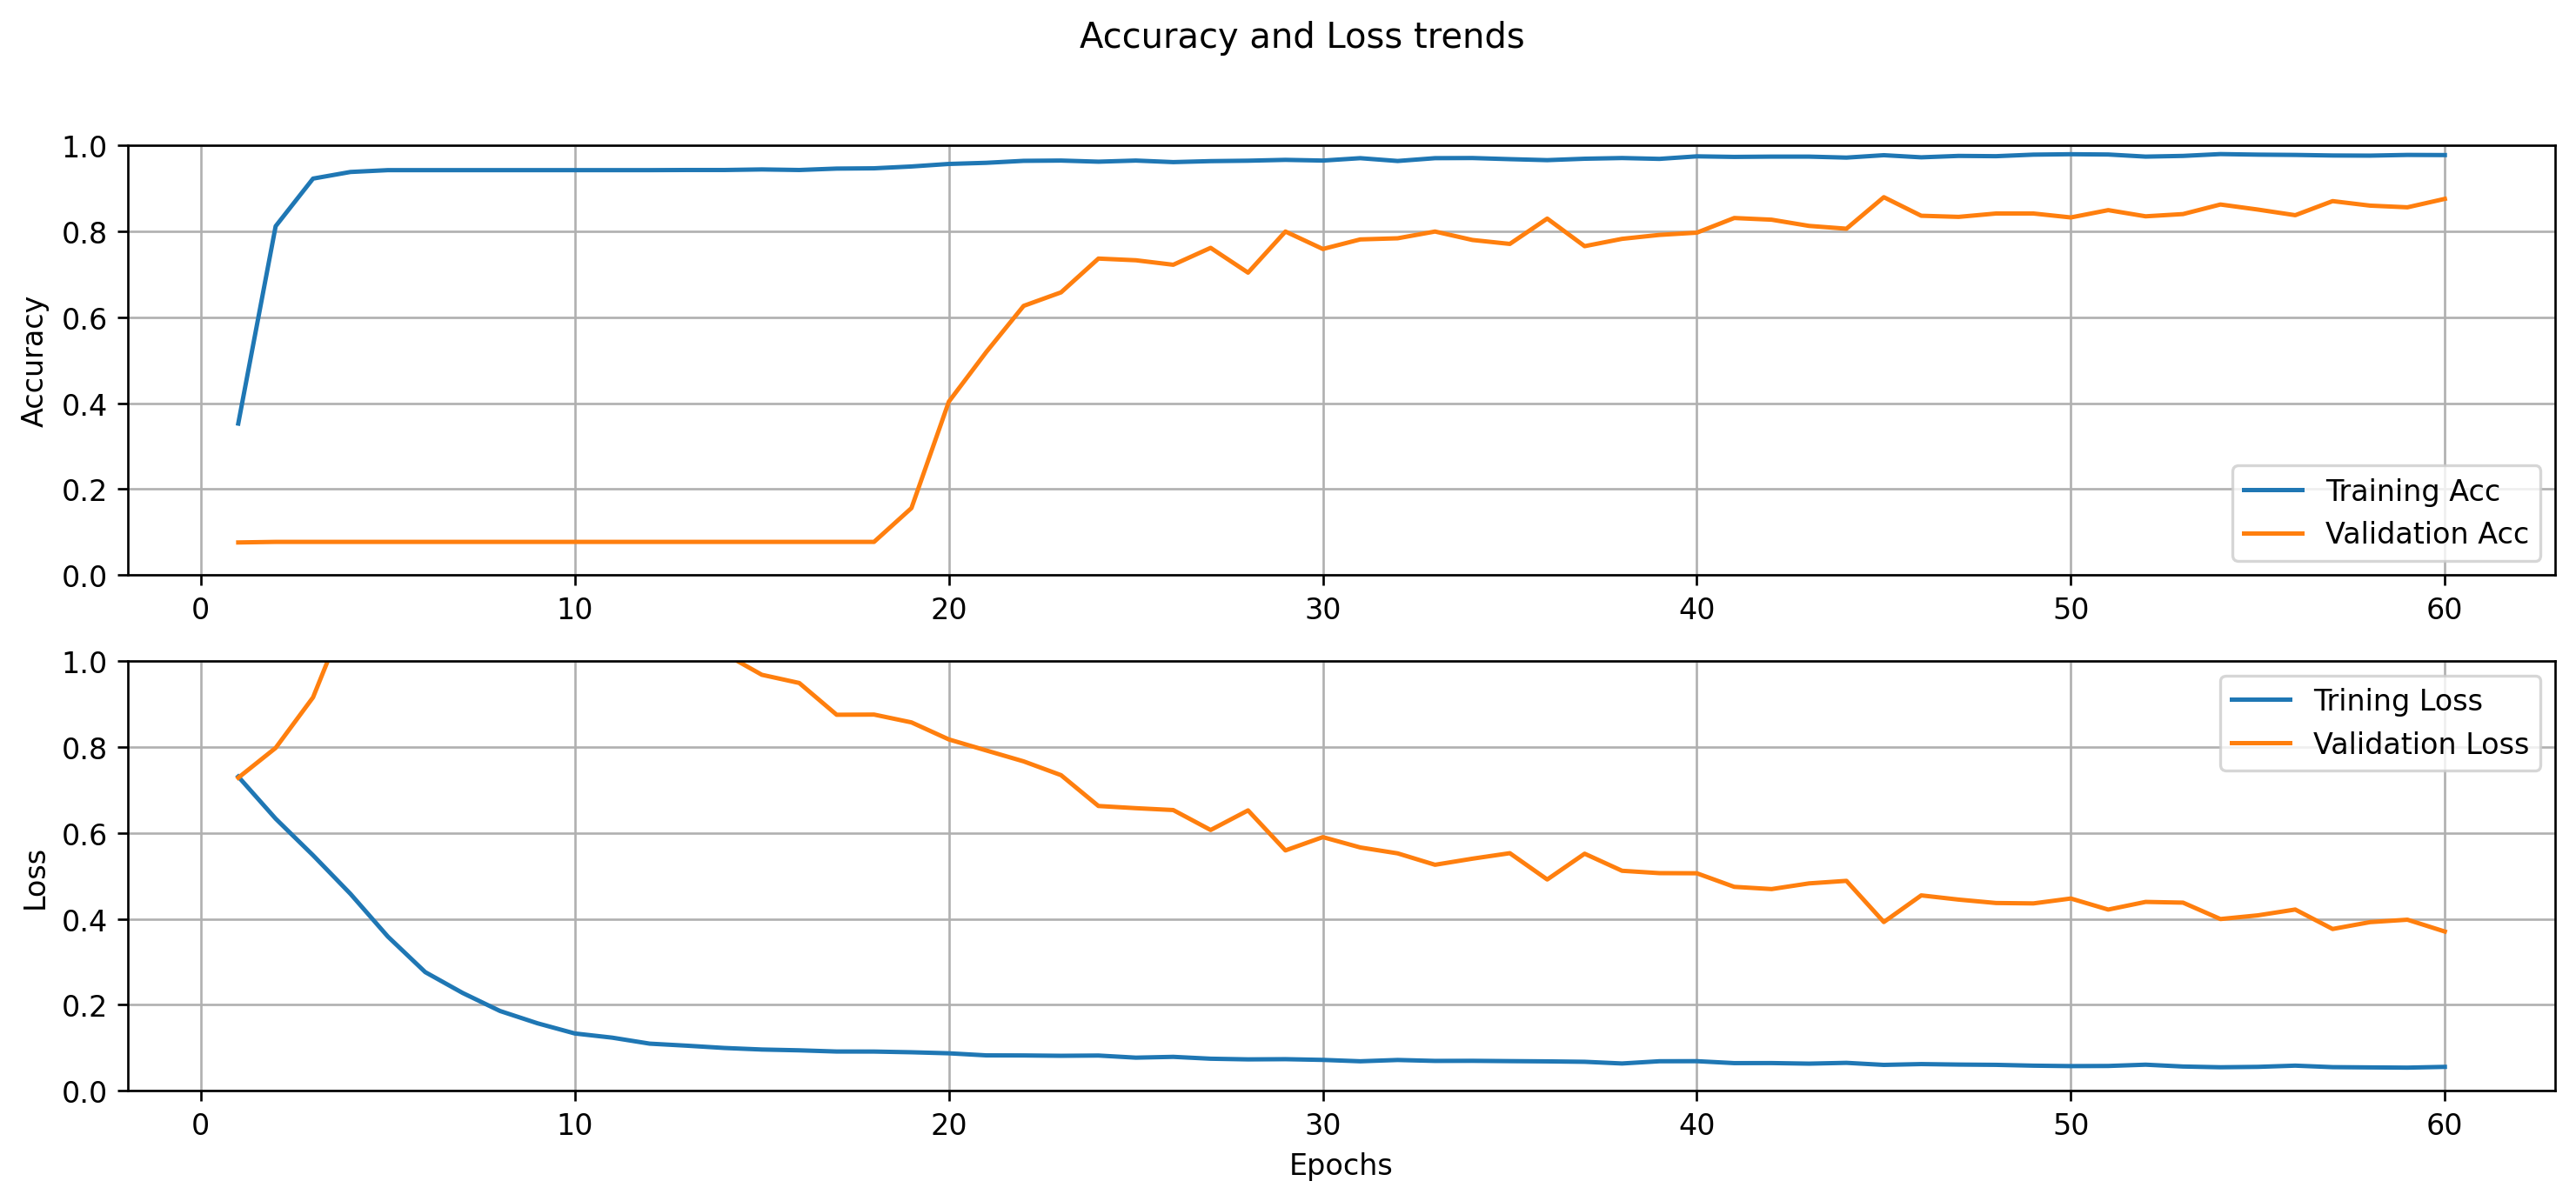

In [205]:
plot_nn_training_history(history)

In [206]:
x_train_test = np.reshape(norm_ov_train_set.values, (len(norm_ov_train_set), 1, len(norm_ov_train_set.columns)))
train_pred = (nn_model_ov.predict(x_train_test) > 0.5).astype("int32")
report_scores(labels, train_pred)

              precision    recall  f1-score   support

         low       0.96      0.99      0.97      2934
        high       0.98      0.85      0.91       880

    accuracy                           0.96      3814
   macro avg       0.97      0.92      0.94      3814
weighted avg       0.96      0.96      0.96      3814



In [207]:
x_test = np.reshape(norm_test_set.values, (len(norm_test_set), 1, len(norm_test_set.columns)))
test_pred = (nn_model_ov.predict(x_test) > 0.5).astype("int32")

In [208]:
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.76      0.84      0.80        77

    accuracy                           0.98      1335
   macro avg       0.88      0.91      0.89      1335
weighted avg       0.98      0.98      0.98      1335



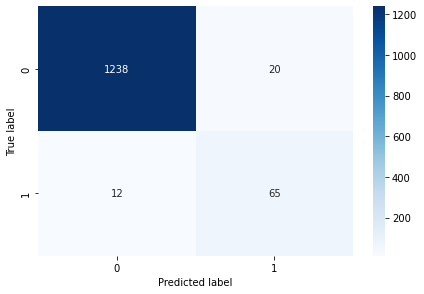

In [209]:
cm=confusion_matrix(test_label,test_pred)
#il parametro fmt serve per evitare la notazione esponenziale dei numeri
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

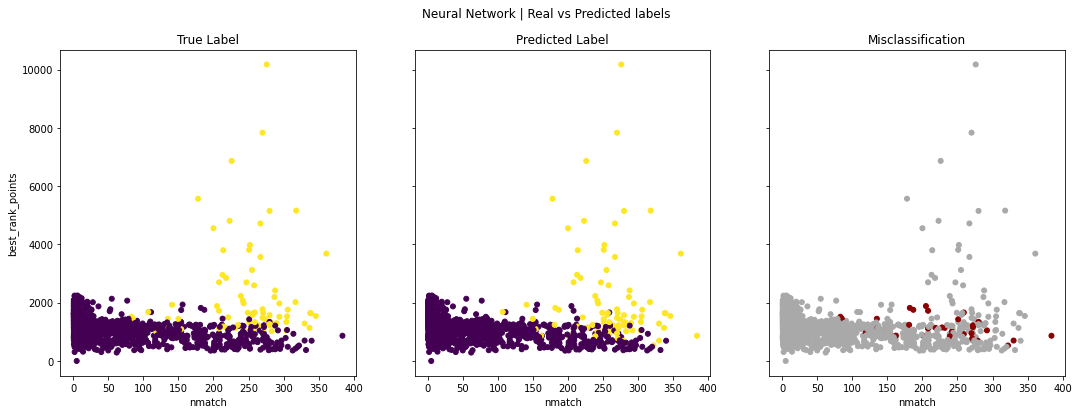

In [210]:
scatter_pred_data(test_set, test_label, test_pred, 'Neural Network', 'nmatch', 'best_rank_points')

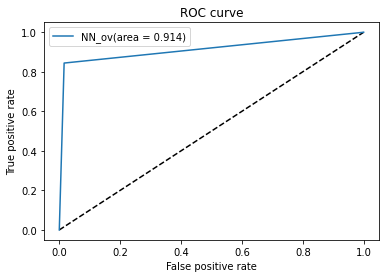

In [211]:
roc_curve_plot(nn_model_ov, norm_test_set, test_label, 'NN_ov')

### KNN (K-Nearest Neighbors)

Let's test the KNN on oversampled dataset.

For the KNN we need to remove the categorical attributes.

In [212]:
knn_ov_train_set = training.drop(columns=['sex_num', 'hand_num'])

In [213]:
k_range = range(1,31)

In [214]:
knn_metrics = ['euclidean', 'manhattan']

In [215]:
knn_weights = ['uniform', 'distance']

In [216]:
knn_algorithms = ['ball_tree', 'kd_tree', 'brute']

In [217]:
knn_param_grid = {
    'n_neighbors': k_range,
    'metric': knn_metrics,
    'algorithm': knn_algorithms,
    'weights': knn_weights
            }

In [218]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
knn_grid.fit(knn_ov_train_set, labels)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [219]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.9853183273556774
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'uniform'}


In [220]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(knn_ov_train_set, labels)
knn_models['knn_ov'] = knn

In [221]:
train_pred = knn.predict(knn_ov_train_set)
report_scores(labels,train_pred)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       880

    accuracy                           1.00      3814
   macro avg       1.00      1.00      1.00      3814
weighted avg       1.00      1.00      1.00      3814



In [222]:
test_pred = knn.predict(knn_test_set)
report_scores(test_label,test_pred)

              precision    recall  f1-score   support

         low       0.98      0.99      0.99      1258
        high       0.82      0.70      0.76        77

    accuracy                           0.97      1335
   macro avg       0.90      0.85      0.87      1335
weighted avg       0.97      0.97      0.97      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


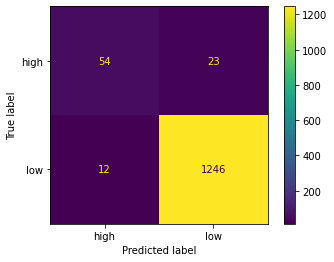

In [223]:
plot_confusion_mx(test_label, test_pred)

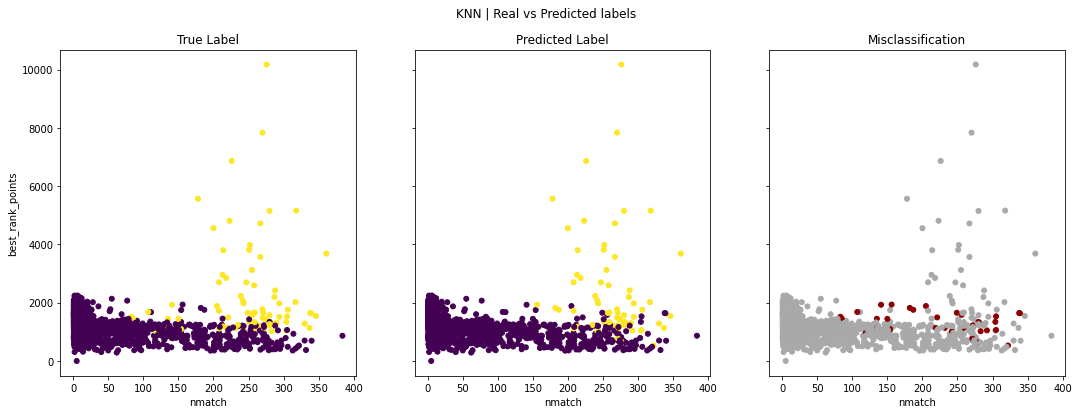

In [224]:
scatter_pred_data(knn_test_set, test_label, test_pred, 'KNN','nmatch', 'best_rank_points')

Train KNN model with normalized oversample dataset.

In [225]:
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=10, scoring='accuracy')
norm_knn_train_set = normalize_dataset(knn_ov_train_set)
norm_knn_test_set = normalize_dataset(knn_test_set)
knn_grid.fit(norm_knn_train_set, labels)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature name

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': range(1, 31),
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [226]:
print('Accuracy: ' + str(knn_grid.best_score_))
print('Parameters: ' + str(knn_grid.best_params_))

Accuracy: 0.982692968352778
Parameters: {'algorithm': 'ball_tree', 'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'uniform'}


In [227]:
knn = KNeighborsClassifier(**knn_grid.best_params_).fit(norm_knn_train_set, labels)

In [228]:
train_pred = knn.predict(norm_knn_train_set)
report_scores(labels,train_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      0.99      0.99       880

    accuracy                           1.00      3814
   macro avg       1.00      0.99      1.00      3814
weighted avg       1.00      1.00      1.00      3814



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [229]:
test_pred = knn.predict(norm_knn_test_set)
report_scores(test_label,test_pred)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         low       0.99      0.97      0.98      1258
        high       0.61      0.81      0.70        77

    accuracy                           0.96      1335
   macro avg       0.80      0.89      0.84      1335
weighted avg       0.97      0.96      0.96      1335



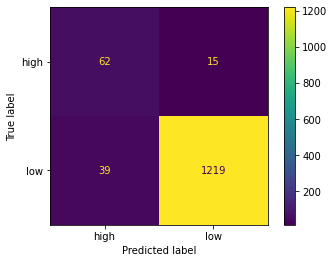

In [230]:
plot_confusion_mx(test_label, test_pred)

### Random Forest

Let's test the Random Forest on oversampled dataset.

In [231]:
rf_models = {}
clf=RandomForestClassifier(n_estimators=100)

clf.fit(training, labels)
rf_models['rf_original'] = clf

train_pred = clf.predict(training)

report_scores(labels, train_pred)

train_pred = clf.predict(train_set)
report_scores(train_label, train_pred)

test_pred = clf.predict(test_set)
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       880

    accuracy                           1.00      3814
   macro avg       1.00      1.00      1.00      3814
weighted avg       1.00      1.00      1.00      3814

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       178

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.82      0.90      0.86        77

    accuracy                           0.98      1335
   macro avg       0.91      0.94      0.92      1335
weighted avg       0.98      0.98      0.98      1335



### AdaBoost

Let's test the AdaBoost on oversampled dataset.

In [232]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(training, labels)

train_pred = model.predict(training)

report_scores(labels, train_pred)

train_pred = model.predict(train_set)
report_scores(train_label, train_pred)

test_pred = model.predict(test_set)
report_scores(test_label, test_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       0.99      0.99      0.99       880

    accuracy                           1.00      3814
   macro avg       0.99      1.00      0.99      3814
weighted avg       1.00      1.00      1.00      3814

              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       0.94      0.98      0.96       178

    accuracy                           1.00      3112
   macro avg       0.97      0.99      0.98      3112
weighted avg       1.00      1.00      1.00      3112

              precision    recall  f1-score   support

         low       1.00      0.99      0.99      1258
        high       0.80      0.92      0.86        77

    accuracy                           0.98      1335
   macro avg       0.90      0.95      0.92      1335
weighted avg       0.98      0.98      0.98      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


# Sumup Classifiers Comparison

In [233]:
classifiers = {}
classifiers.update(dt_models)
classifiers.update(svm_models)
classifiers.update(rb_models)
classifiers.update(gnb_models)
classifiers.update(knn_models)
classifiers.update(nn_models)
classifiers.update(ab_models)
classifiers.update(rf_models)

In this section, the performances of all the analyzed classifiers are compared on the three datasets.

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


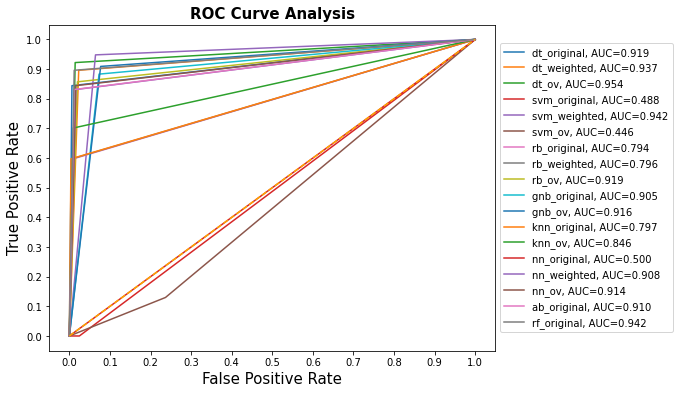

In [234]:
compare_roc_curves(classifiers, test_set, test_label)

### Decision tree versions comparision

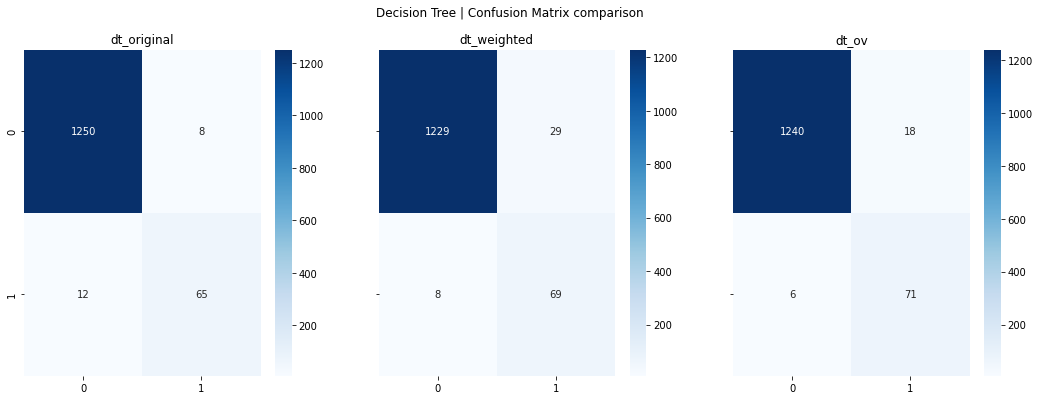

In [235]:
compare_models(dt_models, 'Decision Tree', test_set, test_label)

In [236]:
print('\t\t\t TRAINING SCORES')
compare_scores(dt_models,train_set, train_label)

			 TRAINING SCORES
			dt_original
              precision    recall  f1-score   support

         low       0.99      1.00      1.00      2934
        high       0.98      0.88      0.93       178

    accuracy                           0.99      3112
   macro avg       0.99      0.94      0.96      3112
weighted avg       0.99      0.99      0.99      3112

			dt_weighted
              precision    recall  f1-score   support

         low       1.00      0.97      0.99      2934
        high       0.69      1.00      0.82       178

    accuracy                           0.97      3112
   macro avg       0.85      0.99      0.90      3112
weighted avg       0.98      0.97      0.98      3112

			dt_ov
              precision    recall  f1-score   support

         low       1.00      0.99      0.99      2934
        high       0.87      0.98      0.92       178

    accuracy                           0.99      3112
   macro avg       0.93      0.99      0.96      3112
weighted avg   

In [237]:
print('\t\t\t TEST SCORES')
compare_scores(dt_models,test_set, test_label)

			 TEST SCORES
			dt_original
              precision    recall  f1-score   support

         low       0.99      0.99      0.99      1258
        high       0.89      0.84      0.87        77

    accuracy                           0.99      1335
   macro avg       0.94      0.92      0.93      1335
weighted avg       0.98      0.99      0.98      1335

			dt_weighted
              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.70      0.90      0.79        77

    accuracy                           0.97      1335
   macro avg       0.85      0.94      0.89      1335
weighted avg       0.98      0.97      0.97      1335

			dt_ov
              precision    recall  f1-score   support

         low       1.00      0.99      0.99      1258
        high       0.80      0.92      0.86        77

    accuracy                           0.98      1335
   macro avg       0.90      0.95      0.92      1335
weighted avg       

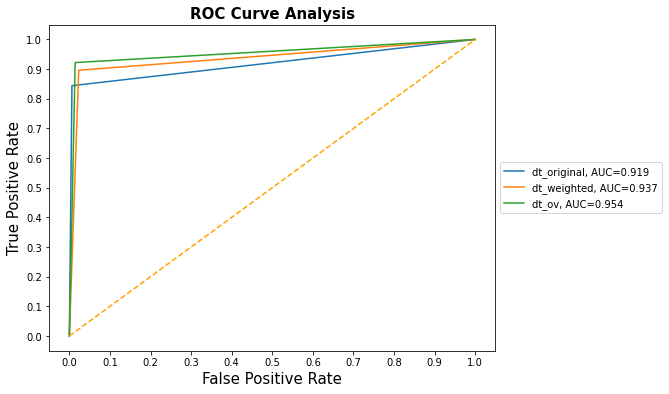

In [238]:
compare_roc_curves(dt_models,test_set, test_label)

### SVM versions comparision

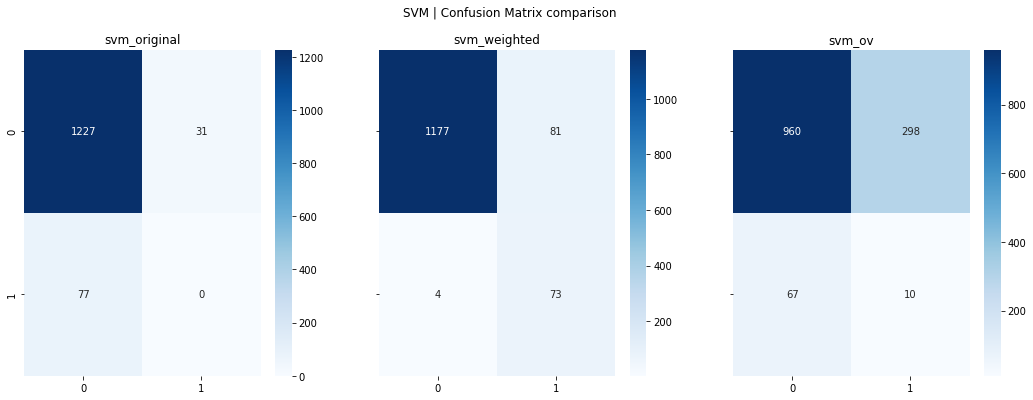

In [239]:
compare_models(svm_models, 'SVM', test_set, test_label)

In [240]:
print('\t\t\t TRAINING SCORES')
compare_scores(svm_models,train_set, train_label)

			 TRAINING SCORES
			svm_original
              precision    recall  f1-score   support

         low       0.94      0.97      0.96      2934
        high       0.00      0.00      0.00       178

    accuracy                           0.92      3112
   macro avg       0.47      0.49      0.48      3112
weighted avg       0.89      0.92      0.90      3112

			svm_weighted
              precision    recall  f1-score   support

         low       1.00      0.94      0.97      2934
        high       0.49      0.98      0.66       178

    accuracy                           0.94      3112
   macro avg       0.75      0.96      0.81      3112
weighted avg       0.97      0.94      0.95      3112

			svm_ov
              precision    recall  f1-score   support

         low       0.94      0.75      0.84      2934
        high       0.04      0.17      0.07       178

    accuracy                           0.72      3112
   macro avg       0.49      0.46      0.45      3112
weighted avg

In [241]:
print('\t\t\t TEST SCORES')
compare_scores(svm_models,test_set, test_label)

			 TEST SCORES
			svm_original
              precision    recall  f1-score   support

         low       0.94      0.98      0.96      1258
        high       0.00      0.00      0.00        77

    accuracy                           0.92      1335
   macro avg       0.47      0.49      0.48      1335
weighted avg       0.89      0.92      0.90      1335

			svm_weighted
              precision    recall  f1-score   support

         low       1.00      0.94      0.97      1258
        high       0.47      0.95      0.63        77

    accuracy                           0.94      1335
   macro avg       0.74      0.94      0.80      1335
weighted avg       0.97      0.94      0.95      1335

			svm_ov
              precision    recall  f1-score   support

         low       0.93      0.76      0.84      1258
        high       0.03      0.13      0.05        77

    accuracy                           0.73      1335
   macro avg       0.48      0.45      0.45      1335
weighted avg    

### Rule based versions comparision

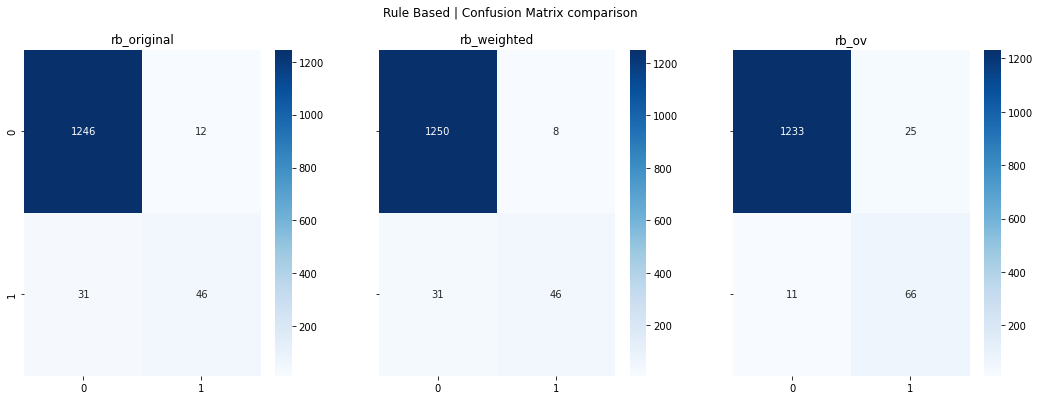

In [242]:
compare_models(rb_models, 'Rule Based', test_set, test_label)

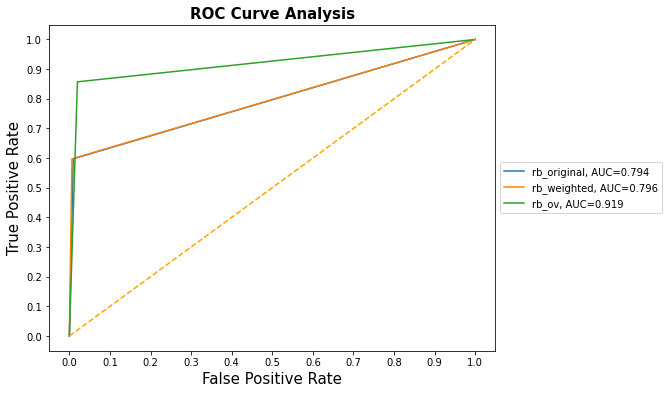

In [243]:
compare_roc_curves(rb_models,test_set, test_label)

In [244]:
print('\t\t\t TRAINING SCORES')
compare_scores(rb_models,train_set, train_label)

			 TRAINING SCORES
			rb_original
              precision    recall  f1-score   support

         low       0.98      1.00      0.99      2934
        high       0.90      0.60      0.72       178

    accuracy                           0.97      3112
   macro avg       0.94      0.80      0.85      3112
weighted avg       0.97      0.97      0.97      3112

			rb_weighted
              precision    recall  f1-score   support

         low       0.98      1.00      0.99      2934
        high       0.94      0.60      0.73       178

    accuracy                           0.97      3112
   macro avg       0.96      0.80      0.86      3112
weighted avg       0.97      0.97      0.97      3112

			rb_ov
              precision    recall  f1-score   support

         low       1.00      0.99      0.99      2934
        high       0.86      0.94      0.90       178

    accuracy                           0.99      3112
   macro avg       0.93      0.96      0.95      3112
weighted avg   

In [245]:
print('\t\t\t TEST SCORES')
compare_scores(rb_models,test_set, test_label)

			 TEST SCORES
			rb_original
              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.79      0.60      0.68        77

    accuracy                           0.97      1335
   macro avg       0.88      0.79      0.83      1335
weighted avg       0.97      0.97      0.97      1335

			rb_weighted
              precision    recall  f1-score   support

         low       0.98      0.99      0.98      1258
        high       0.85      0.60      0.70        77

    accuracy                           0.97      1335
   macro avg       0.91      0.80      0.84      1335
weighted avg       0.97      0.97      0.97      1335

			rb_ov
              precision    recall  f1-score   support

         low       0.99      0.98      0.99      1258
        high       0.73      0.86      0.79        77

    accuracy                           0.97      1335
   macro avg       0.86      0.92      0.89      1335
weighted avg       

### Gaussain Naive Bayes versions comparision

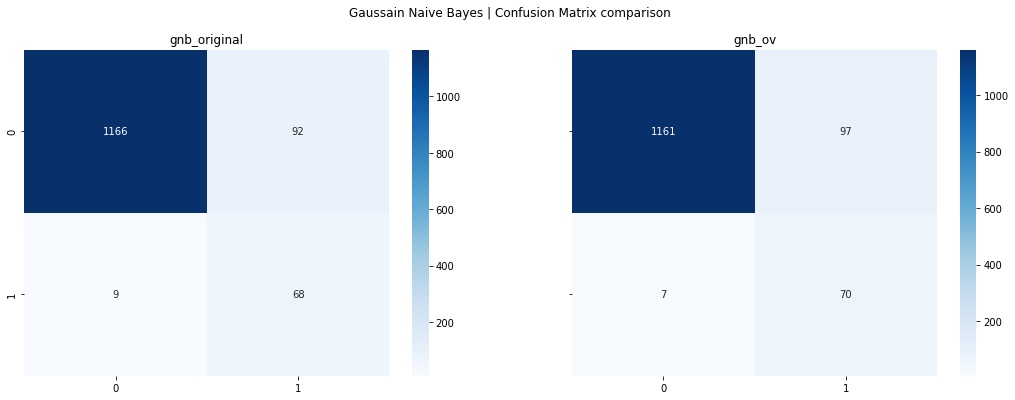

In [246]:
compare_models(gnb_models, 'Gaussain Naive Bayes', test_set, test_label)

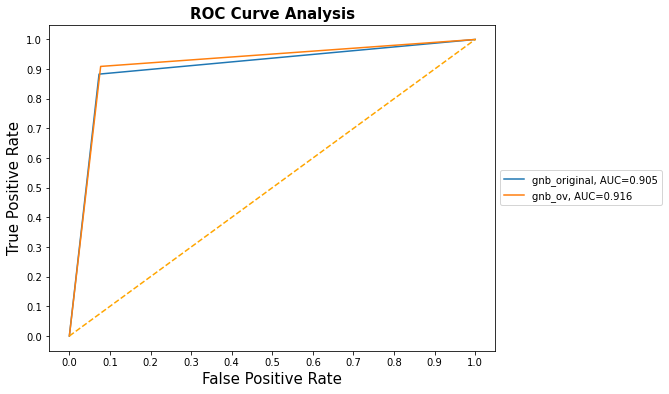

In [247]:
compare_roc_curves(gnb_models,test_set, test_label)

In [248]:
print('\t\t\t TRAINING SCORES')
compare_scores(gnb_models,train_set, train_label)

			 TRAINING SCORES
			gnb_original
              precision    recall  f1-score   support

         low       1.00      0.93      0.96      2934
        high       0.44      0.94      0.60       178

    accuracy                           0.93      3112
   macro avg       0.72      0.93      0.78      3112
weighted avg       0.96      0.93      0.94      3112

			gnb_ov
              precision    recall  f1-score   support

         low       1.00      0.92      0.96      2934
        high       0.43      0.94      0.59       178

    accuracy                           0.93      3112
   macro avg       0.71      0.93      0.78      3112
weighted avg       0.96      0.93      0.94      3112



In [249]:
print('\t\t\t TEST SCORES')
compare_scores(gnb_models,test_set, test_label)

			 TEST SCORES
			gnb_original
              precision    recall  f1-score   support

         low       0.99      0.93      0.96      1258
        high       0.42      0.88      0.57        77

    accuracy                           0.92      1335
   macro avg       0.71      0.90      0.77      1335
weighted avg       0.96      0.92      0.94      1335

			gnb_ov
              precision    recall  f1-score   support

         low       0.99      0.92      0.96      1258
        high       0.42      0.91      0.57        77

    accuracy                           0.92      1335
   macro avg       0.71      0.92      0.77      1335
weighted avg       0.96      0.92      0.94      1335



### Neural Network versions comparision

In [250]:
def compare_nn_models(models_list, classifier_name, test_set, test_label):
    i = 0
    col_count = len(train_set.columns)
    fig, axs = plt.subplots(nrows=1,ncols=len(models_list), figsize=(18,6), sharey=True)
    title = classifier_name + ' | Confusion Matrix comparison'
    plt.suptitle(title)
    for model in models_list.keys():
        x_test = np.reshape(test_set.values, (len(test_set), 1, col_count))
        test_pred = (models_list[model].predict(x_test) > 0.5).astype("int32")
        cm=confusion_matrix(test_label,test_pred)
        sns.heatmap(cm, ax=axs[i], annot=True,cmap=plt.cm.Blues, fmt='g')
        axs[i].set_title(model)
        i+=1

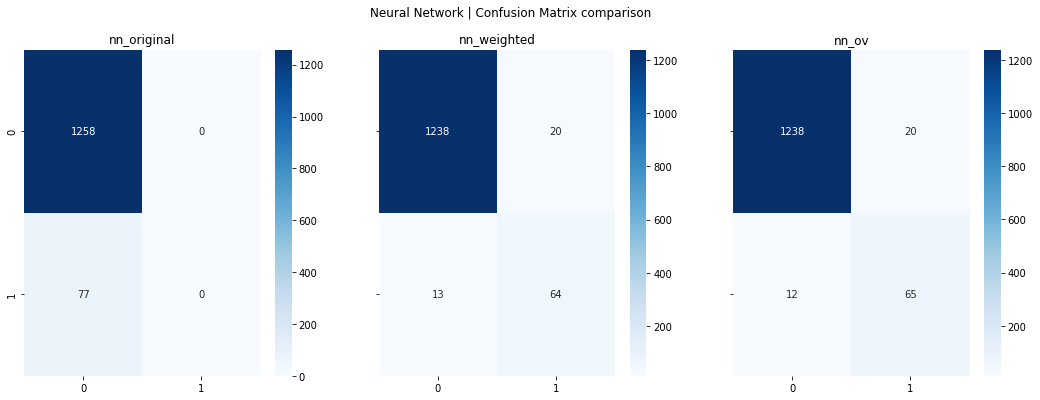

In [251]:
compare_nn_models(nn_models, 'Neural Network',norm_test_set, test_label)

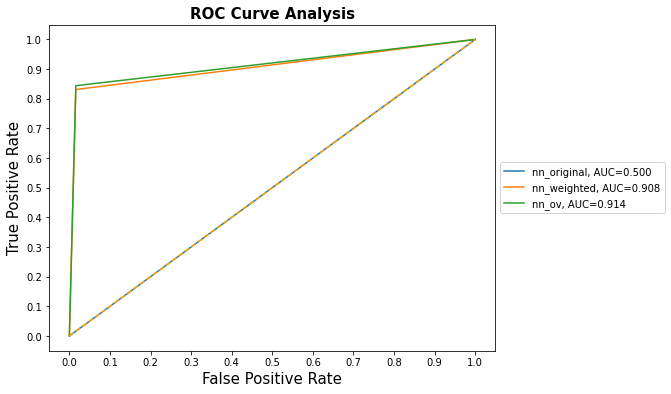

In [252]:
compare_roc_curves(nn_models,test_set, test_label, norm_test_set = norm_test_set)

### KNN versions comparision

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


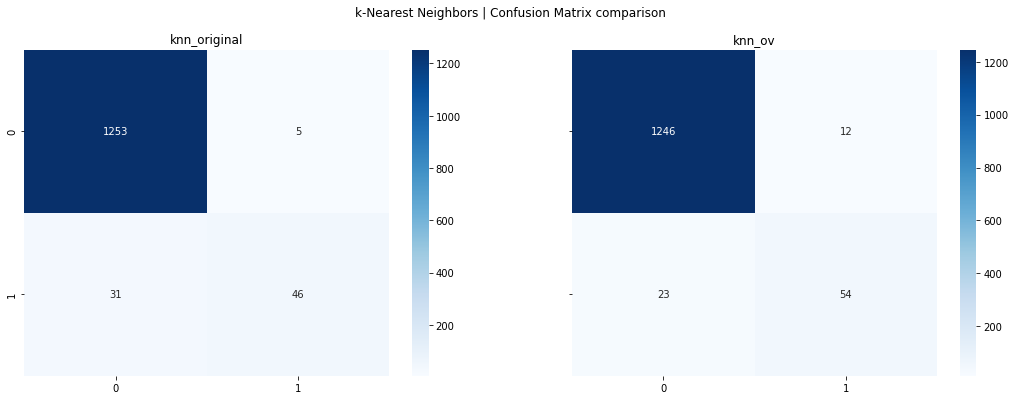

In [253]:
compare_models(knn_models, 'k-Nearest Neighbors', knn_test_set, test_label)

/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


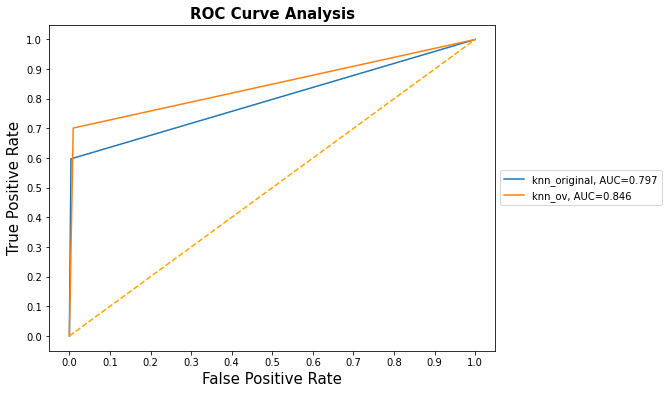

In [254]:
compare_roc_curves(knn_models,test_set, test_label)

In [255]:
print('\t\t\t TRAINING SCORES')
compare_scores(knn_models,knn_train_set, train_label)

			 TRAINING SCORES
			knn_original
              precision    recall  f1-score   support

         low       0.98      0.99      0.99      2934
        high       0.89      0.70      0.78       178

    accuracy                           0.98      3112
   macro avg       0.93      0.85      0.88      3112
weighted avg       0.98      0.98      0.98      3112

			knn_ov


/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

         low       1.00      1.00      1.00      2934
        high       1.00      1.00      1.00       178

    accuracy                           1.00      3112
   macro avg       1.00      1.00      1.00      3112
weighted avg       1.00      1.00      1.00      3112



In [256]:
print('\t\t\t TEST SCORES')
compare_scores(knn_models,knn_test_set, test_label)

			 TEST SCORES
			knn_original
              precision    recall  f1-score   support

         low       0.98      1.00      0.99      1258
        high       0.90      0.60      0.72        77

    accuracy                           0.97      1335
   macro avg       0.94      0.80      0.85      1335
weighted avg       0.97      0.97      0.97      1335

			knn_ov
              precision    recall  f1-score   support

         low       0.98      0.99      0.99      1258
        high       0.82      0.70      0.76        77

    accuracy                           0.97      1335
   macro avg       0.90      0.85      0.87      1335
weighted avg       0.97      0.97      0.97      1335



/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/home/reschini/repository/u/DM_Project/venv/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
